<table style="float:left; border:none">
   <tr style="border:none">
       <td style="border:none">
           <a href="https://bokeh.org/">     
           </a>    
       </td>
       <td style="border:none">
           <h1>Uncertainty Spillover</h1>
       </td>
   </tr>
</table>

<div style="float:right;"><h2>Jump in [$\underline y$, $\overline y$]</h2></div>

In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from solver_1d import false_transient_one_iteration_python
from supportfunctions import PDESolver_2d, finiteDiff
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one_100, solve_smooth_unreveal, generate_weight, solve_smooth_100, value_for_match
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams["lines.linewidth"] = 2.5
mpl.rcParams['legend.frameon'] = False

In [2]:
# parameters
δ = 0.01
η = 0.032
μ = 1.86/1000
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
σy = 1.2*μ
ς = 0.1
# damage function
ȳ = 1.7
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.array([0, 2*0.0197, 2*0.3853])
# y grid
numy_bar = 100
y_min = 1e-10
y_max = 4
hy = (ȳ - y_min)/numy_bar
y_grid = np.arange(y_min, y_max+hy, hy)

In [3]:
# capital parameters
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0085
κ = 6.667
k0 = 80/α

In [4]:
n_temp = 16
n_carb = 9
n_θ = len(θ_list)
θ_mat = θ_list.reshape(n_temp, n_carb)
θtemp_list = np.average(θ_mat, axis=1)
θcarb_list = np.average(θ_mat, axis=0)

# Jump model of damages
Intensity function:
$$
\mathcal{I}(y) = \begin{cases}
(\frac{1}{\sqrt{2\pi} \varsigma})\exp\left[- \frac{(y - \bar y)^2}{2\varsigma^2}\right], \quad y \leqslant \bar y\\
(\frac{1}{\sqrt{2\pi}\varsigma}), \quad y > \bar y
\end{cases}
$$

HJB
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{\pi^d} &- \delta \phi(y) + \eta \log\tilde e \\
    & +  \frac{d\phi}{dy}\sum_i \pi_i^a\theta_i \tilde e  + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2 + \frac{1}{2} \frac{(\eta - 1)}{\delta} \gamma_2 (\tilde e)^2 |\sigma_y|^2\\
& + \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y) \tilde e \sum_i \pi_i^a\theta_i + \mathcal{I}(y)\sum_j \pi^d_j \left[\phi_j(y) - \phi(y) \right] \\
&  + \textbf{relative entropy}
\end{aligned}
$$
## Approach one:
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{g_j} &- \delta \phi(y) +  \eta \log\tilde e + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2  + \frac{\xi_m}{2} h'h\\
& + [ \frac{d\phi}{dy}    + \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y)]\cdot \tilde e \sigma_y h +\frac{1}{2}\frac{ (\eta - 1)}{\delta} \gamma_2 (\tilde e)^2 |\sigma_y|^2\\
& + \sum_i \pi_i^c \frac{d\phi}{dy} \theta_i \tilde e  + \sum_i \pi_i^c \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y) \tilde e \theta_i + \xi_a \sum_i \hat\pi^c_i(\log \pi^c_i - \log \hat\pi^c_i)\\
&  + \mathcal{I}(y)\sum_j\hat\pi_j^d g_j\left[\phi_j(y) - \phi(y) \right]  + \xi_m \mathcal{I}(y) \sum_j \hat\pi_j^d [1 - g_j + g_j \log g_j]
\end{aligned}
$$
The optimal $g_j$:
$$
g_j^* = \exp\{\frac{1}{\xi_m}\left( \phi(y) - \phi_j(y)\right)\}
$$
Plug back in
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{g_j} &- \delta \phi(y) + \eta \log\tilde e + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2 + \frac{1}{2}\frac{(\eta -1)}{\delta}\gamma_2(\tilde e)^2 |\sigma_y|^2\\
& + \sum_i \pi_i^c \left[\frac{d\phi}{dy}  + \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y)\right] \tilde e \theta_i + \xi_a \sum_i \hat\pi^c_i(\log \pi^c_i - \log \hat\pi^c_i) \\
&  +  \xi_m \mathcal{I}(y) \sum_j \hat\pi_j^d [1 - g_j^* ]
\end{aligned}
$$
Intensity altered to be $\iota^*(y) \mathcal{I} (y)$ where:
$$
\iota^*(y)  = \sum_j \hat\pi_j g_j^* 
$$
Distorted probability:
$$
\pi^*_j  = \frac{\exp\left(-\frac{1}{\xi_m} [\phi_j(y) - \phi(y)] \right) \hat\pi_j}{\iota^*(y)}
$$

In [5]:
def simulate_jump(y_grid, solu, ME,  θ_list, y_start=1, T=100, dt=1):
    ems = solu["ems"]
    πᶜ = solu["πc"]
    πᵈ = solu["πd"]
    ι = solu["ι"]
    h = solu["h"]
    periods = int(T/dt)
    et = np.zeros(periods)
    yt = np.zeros(periods)
    πᶜt = np.zeros((periods, len(θ_list)))
    πᵈt = np.zeros((periods, len(πᵈ)))
    ιt = np.zeros(periods)
    ht = np.zeros(periods)
    if ME is not None:
        me_t = np.zeros(periods)
    # interpolate
    get_πᵈ = interpolate.interp1d(y_grid, πᵈ)
    get_πᶜ = interpolate.interp1d(y_grid, πᶜ)
#     y = np.mean(θ_list)*290
    y = y_start
    for t in range(periods):
        if y > np.max(y_grid):
            break
        else:
            ems_point = np.interp(y, y_grid, ems)
            πᵈ_list = get_πᵈ(y)
            πᶜ_list = get_πᶜ(y)
            ι_point = np.interp(y, y_grid, ι)
            h_point = np.interp(y, y_grid, h)
            if ME is not None:
                me_point = np.interp(y, y_grid, ME)
                me_t[t] = me_point
            et[t] = ems_point
            πᵈt[t] = πᵈ_list
            πᶜt[t] = πᶜ_list
            ιt[t] = ι_point
            ht[t] = h_point
            yt[t] = y
            dy = ems_point*np.mean(θ_list)*dt
            y = dy + y
    if ME is not None:
        return yt, et, πᵈt, πᶜt, ιt, ht, me_t
    else:
        return yt, et, πᵈt, πᶜt, ιt, ht

In [6]:
def plot_solu(ht, πᵈt, ϕ_list, solu, args):
    ϕ = solu['φ']
    ξa, ξw, ξp, numy_bar, dmg_weight = args
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))
    fig.suptitle(r'$\xi_a = {}, \quad  \xi_w =1/{}, \quad \xi_p = 1/{} $'.format(ξa, int(1/ξw), int(1/ξp)))
    ax1.plot(ht)
    ax1.set_ylim(bottom=0, top=0.3)
    ax1.set_xlim(left=0)
    ax1.set_xlabel('years')
    ax1.set_ylabel('h')
    if np.count_nonzero(dmg_weight) > 2:
        ax2.plot(πᵈt[:,-1][πᵈt[:,-1]>0], label="extreme damage")
    ax2.plot(πᵈt[:,1][πᵈt[:,1]>0], label="high damage")
    ax2.plot(πᵈt[:,0][πᵈt[:,0]>0], label="low damage")
    # ax2.plot(πᵈt[:,2], label="extreme")
    ax2.set_ylim(bottom=0, top=1)
    ax2.set_xlim(left=0)
    ax2.legend()
    ax2.set_xlabel('years')
    ax2.set_ylabel('πᵈ')
    # plot 3
    ϕ_bound = np.average(np.exp(-1/ξp*ϕ_list), axis=0, weights=dmg_weight)
    ϕ_bound = -ξp*np.log(ϕ_bound)
    ax3.plot(y_grid[:numy_bar+1], ϕ, label='prior to jump')
    ax3.plot(y_grid[numy_bar:], ϕ_list[0][numy_bar:], linestyle="--", color="black", label="post jump, low damage")
    ax3.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:], label="post jump, certainty equivalent")
    ax3.plot(y_grid[numy_bar:], ϕ_list[1][numy_bar:], linestyle="-.", color="black", label="post jump, high damage")
    if np.count_nonzero(dmg_weight) > 2:
        ax3.plot(y_grid[numy_bar:], ϕ_list[-1][numy_bar:], linestyle=":", color="black", label="post jump, extreme damage")
    ax3.vlines(x=2, ymin=-11, ymax=5, linestyle="dashed", color="black")
    # ax3.xlim(0,4)
    # ax3.ylim(-0.02, 0.05)
    ax3.set_ylabel('$\phi$')
    ax3.set_xlabel('y')
    ax3.set_xlim(left=0)
    ax3.legend()
    # ax3.set_title(r'$\xi_a = 1,000, \quad  \xi_w =1/400, \quad \xi_p = 1/400 \times 5 $')
    # plt.savefig("phi_x1.pdf", facecolor="w", edgecolor='w', bbox_inches="tight") 

In [7]:
y_lower = 1.7
y_bar = 2
y_min = 0
y_max = 4
hy = 0.02
y_grid = np.arange(y_min, y_max+hy, hy)
jump_interval = np.arange(y_lower, y_bar, hy)
pre_jump = np.arange(y_min, 1.7+hy, hy)

In [8]:
jump_idx = len(pre_jump)-1
y_grid[jump_idx]

1.7

In [9]:
ξa = 1/10_000*100
ξw = 1000*100
ξp = 1/20*100
dmg_weight = np.array([1/3, 1/3, 1/3])

solu_dict = {}
et_dict = {}
for ȳ in jump_interval:
    pre_jump = np.arange(y_min, ȳ+hy, hy)
    numy_bar = len(pre_jump)-1
    args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
    ϕ_list, π_list = value_for_match(y_grid, numy_bar, args, report_π=True)
#     yt, et, πᵈt, πᶜt, ιt, ht = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list)
    solu_dict[ȳ] = dict(ϕ_list=ϕ_list, π_list=π_list)
#     et_dict[ȳ] = etϕ = np.average(ϕ_list, axis=0, weights=dmg_weight)[:numy_bar+1]

episode: 10000,	 ode error: 0.00044409073248848074,	 ft error: 0.0001501373789647431
episode: 5048,	 ode error: 0.0003089769257152569,	 ft error: 9.98960469900112e-09
episode: 5393,	 ode error: 0.0012185046732560122,	 ft error: 9.979702989918831e-09
episode: 10000,	 ode error: 0.00044409073248848074,	 ft error: 0.0001501373789647431
episode: 5048,	 ode error: 0.0003093762603368702,	 ft error: 9.982256502875469e-09
episode: 5391,	 ode error: 0.0012334243617965574,	 ft error: 9.977441095543327e-09
episode: 10000,	 ode error: 0.00044409073248848074,	 ft error: 0.0001501373789647431
episode: 5047,	 ode error: 0.00030978942024931927,	 ft error: 9.996975099587265e-09
episode: 5388,	 ode error: 0.0012512570187300492,	 ft error: 9.997235631923711e-09
episode: 10000,	 ode error: 0.00044409073248848074,	 ft error: 0.0001501373789647431
episode: 5046,	 ode error: 0.000310217314157174,	 ft error: 9.995397102594932e-09
episode: 5386,	 ode error: 0.0012728522324090578,	 ft error: 9.978394407047139e-

In [167]:
r1 = -54.16692119
r1

-54.16692119

In [168]:
r0_list, time_interval_list = ([-4.382975767906238, -1.0957439419765596], [0.25, 1])
r0_list, time_interval_list

([-4.382975767906238, -1.0957439419765596], [0.25, 1])

In [169]:
y_short = np.arange(y_min, 2 + hy, hy)
short_idx = len(y_short) -1
y_grid[:short_idx+1]

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06, 1.08,
       1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 , 1.22, 1.24, 1.26, 1.28, 1.3 ,
       1.32, 1.34, 1.36, 1.38, 1.4 , 1.42, 1.44, 1.46, 1.48, 1.5 , 1.52,
       1.54, 1.56, 1.58, 1.6 , 1.62, 1.64, 1.66, 1.68, 1.7 , 1.72, 1.74,
       1.76, 1.78, 1.8 , 1.82, 1.84, 1.86, 1.88, 1.9 , 1.92, 1.94, 1.96,
       1.98, 2.  ])

In [170]:
y_shortest = np.arange(y_min, y_lower, hy)
shortest_idx = len(y_shortest)
y_grid[shortest_idx],y_shortest

(1.7,
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06, 1.08,
        1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 , 1.22, 1.24, 1.26, 1.28, 1.3 ,
        1.32, 1.34, 1.36, 1.38, 1.4 , 1.42, 1.44, 1.46, 1.48, 1.5 , 1.52,
        1.54, 1.56, 1.58, 1.6 , 1.62, 1.64, 1.66, 1.68]))

In [171]:
weighted = np.zeros_like(y_short)

for i in range(len(jump_interval)):
    ϕ_list = solu_dict[jump_interval[i]]['φ_list']
    weight = np.average(np.exp(-1/ξp*ϕ_list), axis=0, weights=dmg_weight)
    weighted[i + shortest_idx] = weight[i+shortest_idx]
    
# for i in range(len(y_shortest)):
#     ϕ_list = solu_dict[jump_interval[0]]['φ_list']
#     weight = np.average(np.exp(-1/ξp*ϕ_list), axis=0, weights=dmg_weight)
#     weighted[i] = weight[i]

In [172]:
weighted.shape, y_grid[:short_idx+1].shape,  jump_interval

((101,),
 (101,),
 array([1.7 , 1.72, 1.74, 1.76, 1.78, 1.8 , 1.82, 1.84, 1.86, 1.88, 1.9 ,
        1.92, 1.94, 1.96, 1.98, 2.  ]))

In [191]:
weighted[:-1]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [192]:
y_grid_cap.shape, ϕ.shape, solu_dict[2]['φ_list']

((100,),
 (100,),
 array([[ 5.84626689e+00,  5.82783362e+00,  5.80941351e+00,
          5.79106022e+00,  5.77285700e+00,  5.75454216e+00,
          5.73646855e+00,  5.71831327e+00,  5.70029551e+00,
          5.68229630e+00,  5.66436828e+00,  5.64649190e+00,
          5.62867301e+00,  5.61090952e+00,  5.59320180e+00,
          5.57554934e+00,  5.55795200e+00,  5.54040946e+00,
          5.52292150e+00,  5.50548784e+00,  5.48810823e+00,
          5.47078242e+00,  5.45351016e+00,  5.43629118e+00,
          5.41912524e+00,  5.40201207e+00,  5.38495144e+00,
          5.36794308e+00,  5.35098675e+00,  5.33408220e+00,
          5.31722917e+00,  5.30042741e+00,  5.28367668e+00,
          5.26697673e+00,  5.25032731e+00,  5.23372817e+00,
          5.21717906e+00,  5.20067975e+00,  5.18422998e+00,
          5.16782951e+00,  5.15147809e+00,  5.13517549e+00,
          5.11892145e+00,  5.10271573e+00,  5.08655810e+00,
          5.07044830e+00,  5.05438610e+00,  5.03837125e+00,
          5.02240352e+

$$
\begin{aligned}
0 = \max_{\tilde e} &- \delta \phi(y) + \eta \log\tilde e\\
\\
&+ \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2 + \frac{1}{2}\frac{(\eta -1)}{\delta}\gamma_2(\tilde e)^2 |\sigma_y|^2\\
\\
& + \sum_i \pi_i^c \left[\frac{d\phi}{dy}  + \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y)\right] \tilde e \theta_i + \xi_a \sum_i \hat\pi^c_i(\log \pi^c_i - \log \hat\pi^c_i) \\
\\
    &  -   \xi_p \mathcal{I}(y)  \cfrac{ \sum_{m=1}^M\hat\pi_m^p \exp\left( - \frac{1}{\xi_p} \phi_m\right) - \exp\left( -\frac{1}{\xi_p} \phi \right)}{\exp\left( - \frac{1}{\xi_p} \phi\right)}
\end{aligned}
$$

In [220]:
# solve ϕ
ξp=5
tol=1e-6
max_iter= 5000
ϵ = 0.25

solu_list = []
for i in range(len(r0_list)):
    
    intensity = r0_list[i]*(np.exp(r1/2*(y_grid[:short_idx]- y_lower)**2)-1)*(y_grid[:short_idx]>=y_lower)
    y_grid_cap = y_grid[:short_idx]
    dΛ = γ1 + γ2*y_grid_cap
    ddΛ = γ2
    ems = η
    ems_old = ems

    episode = 0
    lhs_error = 1
    πᵈo = dmg_weight
    πᶜo = np.ones((len(θ_list), len(y_grid_cap)))/len(θ_list)
    ϕ = np.average(solu_dict[2]['φ_list'], axis=0, weights=dmg_weight)[:short_idx]

    while lhs_error > tol and episode < max_iter:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, hy, "up")
        dϕdyy = derivative_1d(ϕ, 2, hy, "up")
        # update control
        temp = dϕdy + (η-1)/δ*dΛ 
        weight = np.array([ - 1/ξa*temp*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        πᶜ = πᶜo*np.exp(weight)
        πᶜ[πᶜ <= 1e-15] = 1e-15
        πᶜ = πᶜ/np.sum(πᶜ, axis=0)
        # update control
        a = (dϕdyy  - 1/ξw*temp**2 + (η-1)/δ*ddΛ)*σy**2
        b = (θ_list@πᶜ)*temp - ξp*intensity*(weighted[:-1] - np.exp(-1/ξp*ϕ))/np.exp(-1/ξp*ϕ)
        c = η
        Δ = b**2 - 4*a*c
        Δ[Δ < 0] = 0
        root1 = (-b - np.sqrt(Δ))/(2*a)
        root2 = (-b + np.sqrt(Δ))/(2*a)
        if root1.all() > 0:
            ems_new = root1
        else:
            ems_new = root2
        ems_new[ems_new < 1e-15] = 1e-15
        ems = ems_new*0.5 + ems_old*0.5
        #     g_list = np.array([np.exp(1/ξp*(ϕ - ϕ_list[i][:numy_bar+1])) for i in range(len(γ3_list))])
        # coefficients
        A = -δ*np.ones(y_grid_cap.shape)
        By = (θ_list@πᶜ)*ems
        Cyy = ems**2*σy**2/2
        D = η*np.log(ems) + θ_list@πᶜ*(η-1)/δ*dΛ*ems\
        + ξa*np.sum(πᶜ*(np.log(πᶜ) - np.log(πᶜo)), axis=0) \
        - 1/(2*ξw)*temp**2*ems**2*σy**2\
        + 1/2*(η-1)/δ*ddΛ*ems**2*σy**2\
        - ξp*intensity*(weighted[:-1] - np.exp(-1/ξp*ϕ))/np.exp(-1/ξp*ϕ)
        # solver
        ϕ_new = solve_ode(A, By, Cyy, D, y_grid_cap, ϕ, ϵ, (False, weighted[short_idx]))
        rhs = -δ*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        episode += 1
        ems_old = ems
        print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))
    # dϕdy = derivative_1d(ϕ, 1, dy, "up")
    # dϕdyy = derivative_1d(ϕ, 2, dy, "up")
    temp = dϕdy + (η-1)/δ*dΛ 
    h =  - temp*ems*σy/ξw
    # ι, πᵈ = get_ι(πᵈo, g_list)
    # penalty = ξp*get_intensity(y_grid_cap, ς)*(πᵈo@(1 - g_list))
    solution = dict(ϕ=ϕ, ems=ems)
    solu_list.append(solution)

episode: 1,	 ode error: 4.120100425484667,	 ft error: 4.120111811477968
episode: 2,	 ode error: 1.4009652880388712,	 ft error: 1.4009312889880676
episode: 3,	 ode error: 0.8956792810088041,	 ft error: 0.8955897250784322
episode: 4,	 ode error: 2.4105522062209834,	 ft error: 0.6624526028298563
episode: 5,	 ode error: 0.5222015937001367,	 ft error: 0.5218929275848199
episode: 6,	 ode error: 54.66422327651867,	 ft error: 0.43536421746608145
episode: 7,	 ode error: 3.3409549587049368,	 ft error: 0.37891308723803796
episode: 8,	 ode error: 1.5663550696743398,	 ft error: 0.33010284408326385
episode: 9,	 ode error: 0.729246811822668,	 ft error: 0.2876648672413369
episode: 10,	 ode error: 0.29064241064940455,	 ft error: 0.25620547136680205
episode: 11,	 ode error: 162.66452238823874,	 ft error: 0.23995309099817952
episode: 12,	 ode error: 1.5130703947506432,	 ft error: 0.224752405619296
episode: 13,	 ode error: 0.49002235964910057,	 ft error: 0.21050855199338603
episode: 14,	 ode error: 5.3977

episode: 201,	 ode error: 0.027756977290111232,	 ft error: 0.02881565159287014
episode: 202,	 ode error: 0.027664205634667205,	 ft error: 0.02868174183244765
episode: 203,	 ode error: 0.027566665072657596,	 ft error: 0.028541762875349264
episode: 204,	 ode error: 0.027464243408768057,	 ft error: 0.028395578564285096
episode: 205,	 ode error: 0.027356827475298693,	 ft error: 0.028243053455867972
episode: 206,	 ode error: 0.027244303430737804,	 ft error: 0.028084053386513652
episode: 207,	 ode error: 0.027126557089969184,	 ft error: 0.027931884465842494
episode: 208,	 ode error: 0.027003474287547437,	 ft error: 0.0278520459504783
episode: 209,	 ode error: 0.02687494127536514,	 ft error: 0.027767780278393772
episode: 210,	 ode error: 0.026740845155909954,	 ft error: 0.02767897356722937
episode: 211,	 ode error: 0.02660107435213277,	 ft error: 0.027585509880253767
episode: 212,	 ode error: 0.026455519114752978,	 ft error: 0.027487271418709547
episode: 213,	 ode error: 0.026342809779180406,

episode: 310,	 ode error: 0.018345300993525174,	 ft error: 0.01890024691030323
episode: 311,	 ode error: 0.018267129962986708,	 ft error: 0.018838712791646728
episode: 312,	 ode error: 0.01820800075718349,	 ft error: 0.018774528014046332
episode: 313,	 ode error: 0.01815603472996938,	 ft error: 0.018707630479563697
episode: 314,	 ode error: 0.01810174588064794,	 ft error: 0.01863795780423594
episode: 315,	 ode error: 0.01804507894457024,	 ft error: 0.018565447467335794
episode: 316,	 ode error: 0.017985978162495832,	 ft error: 0.01849003697408147
episode: 317,	 ode error: 0.017924387389658465,	 ft error: 0.018411664032398356
episode: 318,	 ode error: 0.017860250215530747,	 ft error: 0.01834854528419605
episode: 319,	 ode error: 0.017793510094714922,	 ft error: 0.018296003807153127
episode: 320,	 ode error: 0.017724110489352893,	 ft error: 0.018241117425855435
episode: 321,	 ode error: 0.017651995023411127,	 ft error: 0.01818382947333852
episode: 322,	 ode error: 0.01757954555742517,	 f

episode: 420,	 ode error: 0.01273488166755829,	 ft error: 0.013054699138216108
episode: 421,	 ode error: 0.012691862916856034,	 ft error: 0.013017556452394885
episode: 422,	 ode error: 0.012647324453618304,	 ft error: 0.01297900807689345
episode: 423,	 ode error: 0.012602557609298098,	 ft error: 0.012939023981072495
episode: 424,	 ode error: 0.012567915218815971,	 ft error: 0.012897574033525316
episode: 425,	 ode error: 0.012531959440756281,	 ft error: 0.012854628060305018
episode: 426,	 ode error: 0.012494662209982563,	 ft error: 0.012810155907640564
episode: 427,	 ode error: 0.012455995335876976,	 ft error: 0.012764127509157674
episode: 428,	 ode error: 0.012415930553560724,	 ft error: 0.012724747661049918
episode: 429,	 ode error: 0.012374439579075351,	 ft error: 0.012688741751789578
episode: 430,	 ode error: 0.01233149416863058,	 ft error: 0.012651386812718712
episode: 431,	 ode error: 0.012287687586011453,	 ft error: 0.012612654276068724
episode: 432,	 ode error: 0.012254001490903

episode: 530,	 ode error: 0.009071669125412817,	 ft error: 0.00928534974401174
episode: 531,	 ode error: 0.00904652385964691,	 ft error: 0.00925731941230623
episode: 532,	 ode error: 0.009021157528862317,	 ft error: 0.009228398932076942
episode: 533,	 ode error: 0.00899496820772816,	 ft error: 0.009198572635639835
episode: 534,	 ode error: 0.008967940821614222,	 ft error: 0.00917082245456946
episode: 535,	 ode error: 0.008940060325102167,	 ft error: 0.009145301125812466
episode: 536,	 ode error: 0.00891131172981069,	 ft error: 0.009118949399551823
episode: 537,	 ode error: 0.008885274879270738,	 ft error: 0.00909175206723134
episode: 538,	 ode error: 0.008860617499916838,	 ft error: 0.0090636939516191
episode: 539,	 ode error: 0.008835163247891027,	 ft error: 0.009034759934955616
episode: 540,	 ode error: 0.008808897574641969,	 ft error: 0.009006477363309173
episode: 541,	 ode error: 0.008781805956651095,	 ft error: 0.008981625545525063
episode: 542,	 ode error: 0.008753873921783728,	 

episode: 737,	 ode error: 0.005086748115979353,	 ft error: 0.005085817374755663
episode: 738,	 ode error: 0.0050724905773922024,	 ft error: 0.005071181108444733
episode: 739,	 ode error: 0.005057865543439746,	 ft error: 0.0050561721093700385
episode: 740,	 ode error: 0.005042868142275891,	 ft error: 0.005040785560787242
episode: 741,	 ode error: 0.0050274935646116015,	 ft error: 0.005025016716853514
episode: 742,	 ode error: 0.005011737072435726,	 ft error: 0.005008860911651425
episode: 743,	 ode error: 0.004995594008028237,	 ft error: 0.0049923135684686315
episode: 744,	 ode error: 0.004979059803249378,	 ft error: 0.00497537020932981
episode: 745,	 ode error: 0.004962129989104447,	 ft error: 0.004958026464830567
episode: 746,	 ode error: 0.004944800205567132,	 ft error: 0.004940278084198724
episode: 747,	 ode error: 0.00492706621165892,	 ft error: 0.004922120945568764
episode: 748,	 ode error: 0.004908923895762252,	 ft error: 0.004903551066568923
episode: 749,	 ode error: 0.0048903692

episode: 845,	 ode error: 0.0031157512681194988,	 ft error: 0.0016524267849256091
episode: 846,	 ode error: 0.0031156254480856575,	 ft error: 0.0016197953839451884
episode: 847,	 ode error: 0.003115496726550036,	 ft error: 0.0015875426378002544
episode: 848,	 ode error: 0.003115365723030658,	 ft error: 0.001555673655232681
episode: 849,	 ode error: 0.0031152330257247056,	 ft error: 0.0015241931564489164
episode: 850,	 ode error: 0.003115099186292875,	 ft error: 0.0014931054765021656
episode: 851,	 ode error: 0.003114964716252038,	 ft error: 0.0014624145693140633
episode: 852,	 ode error: 0.0031148300847672183,	 ft error: 0.0014321240123109646
episode: 853,	 ode error: 0.003114695717655278,	 ft error: 0.0014022370115291949
episode: 854,	 ode error: 0.0031145619974382935,	 ft error: 0.0013727564073562348
episode: 855,	 ode error: 0.0031144292642222744,	 ft error: 0.0013436846807124425
episode: 856,	 ode error: 0.0031142978172170113,	 ft error: 0.0013150239597230495
episode: 857,	 ode err

episode: 950,	 ode error: 0.0031094907148642836,	 ft error: 0.00010000173322310957
episode: 951,	 ode error: 0.003109479898892464,	 ft error: 9.67903579081053e-05
episode: 952,	 ode error: 0.0031094693860274723,	 ft error: 9.36703139515771e-05
episode: 953,	 ode error: 0.0031094591683196067,	 ft error: 9.063926216867912e-05
episode: 954,	 ode error: 0.0031094492380144435,	 ft error: 8.769491404336804e-05
episode: 955,	 ode error: 0.0031094395875492474,	 ft error: 8.483503105338741e-05
episode: 956,	 ode error: 0.003109430209548958,	 ft error: 8.205742396327764e-05
episode: 957,	 ode error: 0.003109421096816509,	 ft error: 7.935995209962243e-05
episode: 958,	 ode error: 0.003109412242338251,	 ft error: 7.674052264761144e-05
episode: 959,	 ode error: 0.003109403639269627,	 ft error: 7.419708986589058e-05
episode: 960,	 ode error: 0.0031093952809387437,	 ft error: 7.172765442575724e-05
episode: 961,	 ode error: 0.0031093871608374075,	 ft error: 6.933026264732689e-05
episode: 962,	 ode err

episode: 1059,	 ode error: 0.003109137842924955,	 ft error: 4.724469977901435e-06
episode: 1060,	 ode error: 0.0031091375279893845,	 ft error: 4.7103875484566515e-06
episode: 1061,	 ode error: 0.0031091372254507185,	 ft error: 4.695573466051428e-06
episode: 1062,	 ode error: 0.003109136934920091,	 ft error: 4.6800344843944686e-06
episode: 1063,	 ode error: 0.0031091366560195913,	 ft error: 4.663777890101528e-06
episode: 1064,	 ode error: 0.0031091363883811746,	 ft error: 4.646811518682625e-06
episode: 1065,	 ode error: 0.0031091361316506333,	 ft error: 4.629143711909478e-06
episode: 1066,	 ode error: 0.003109135885482891,	 ft error: 4.610783308933719e-06
episode: 1067,	 ode error: 0.003109135649542351,	 ft error: 4.59729210611215e-06
episode: 1068,	 ode error: 0.0031091354235058717,	 ft error: 4.5831170574217595e-06
episode: 1069,	 ode error: 0.0031091352070596514,	 ft error: 4.5682547451519895e-06
episode: 1070,	 ode error: 0.0031091349998983737,	 ft error: 4.552711718730507e-06
episo

episode: 1165,	 ode error: 0.003109133612890766,	 ft error: 3.331478421131351e-06
episode: 1166,	 ode error: 0.003109133664987728,	 ft error: 3.321820255308694e-06
episode: 1167,	 ode error: 0.0031091337172980196,	 ft error: 3.3120032405520305e-06
episode: 1168,	 ode error: 0.003109133769807546,	 ft error: 3.3018181753163844e-06
episode: 1169,	 ode error: 0.0031091338225034335,	 ft error: 3.291268107830092e-06
episode: 1170,	 ode error: 0.0031091338753707794,	 ft error: 3.2803562657335306e-06
episode: 1171,	 ode error: 0.003109133928397838,	 ft error: 3.269086056079118e-06
episode: 1172,	 ode error: 0.0031091339815718377,	 ft error: 3.25965847558507e-06
episode: 1173,	 ode error: 0.003109134034882435,	 ft error: 3.250035881308122e-06
episode: 1174,	 ode error: 0.003109134088317693,	 ft error: 3.2400568521495643e-06
episode: 1175,	 ode error: 0.003109134141865616,	 ft error: 3.2297243404144638e-06
episode: 1176,	 ode error: 0.0031091341955158027,	 ft error: 3.2190414742672147e-06
episod

episode: 1266,	 ode error: 0.003109138662413838,	 ft error: 2.443617075797988e-06
episode: 1267,	 ode error: 0.003109138703490163,	 ft error: 2.4361041344178602e-06
episode: 1268,	 ode error: 0.0031091387443334603,	 ft error: 2.428365890594364e-06
episode: 1269,	 ode error: 0.0031091387849433647,	 ft error: 2.4213691816044047e-06
episode: 1270,	 ode error: 0.003109138825317801,	 ft error: 2.414404852046914e-06
episode: 1271,	 ode error: 0.0031091388654572935,	 ft error: 2.4072161757260346e-06
episode: 1272,	 ode error: 0.0031091389053609867,	 ft error: 2.399805124397858e-06
episode: 1273,	 ode error: 0.0031091389450281434,	 ft error: 2.3921737515308905e-06
episode: 1274,	 ode error: 0.0031091389844586804,	 ft error: 2.385406126848011e-06
episode: 1275,	 ode error: 0.0031091390236512185,	 ft error: 2.378520298051967e-06
episode: 1276,	 ode error: 0.0031091390626059694,	 ft error: 2.371415057211834e-06
episode: 1277,	 ode error: 0.0031091391013213076,	 ft error: 2.364092365425563e-06
epi

episode: 1463,	 ode error: 0.003109141121009025,	 ft error: 1.0864703945401288e-06
episode: 1464,	 ode error: 0.0031091411060314086,	 ft error: 1.0764457165635122e-06
episode: 1465,	 ode error: 0.003109141090946784,	 ft error: 1.0664256073766865e-06
episode: 1466,	 ode error: 0.0031091410757610183,	 ft error: 1.0564118362310637e-06
episode: 1467,	 ode error: 0.003109141060476883,	 ft error: 1.046406151061774e-06
episode: 1468,	 ode error: 0.003109141045098471,	 ft error: 1.036410278487665e-06
episode: 1469,	 ode error: 0.0031091410296299957,	 ft error: 1.026425920258589e-06
episode: 1470,	 ode error: 0.0031091410140768536,	 ft error: 1.0164547568081161e-06
episode: 1471,	 ode error: 0.003109140998443463,	 ft error: 1.006498429489966e-06
episode: 1472,	 ode error: 0.0031091409827322634,	 ft error: 9.96558590315999e-07
episode: 1,	 ode error: 1.1201695238957239,	 ft error: 1.120138022945774
episode: 2,	 ode error: 0.842053859805601,	 ft error: 0.8420608247456141
episode: 3,	 ode error: 0

episode: 98,	 ode error: 0.042764016155527225,	 ft error: 0.045930119866524066
episode: 99,	 ode error: 0.04264305634415399,	 ft error: 0.046100840712573365
episode: 100,	 ode error: 0.04251568563278768,	 ft error: 0.045816336749442854
episode: 101,	 ode error: 0.04237860743098846,	 ft error: 0.04562454098363489
episode: 102,	 ode error: 0.042232787790578985,	 ft error: 0.0449736840025583
episode: 103,	 ode error: 0.04207451817809977,	 ft error: 0.04470083402305036
episode: 104,	 ode error: 0.041906357027915855,	 ft error: 0.04441154439828576
episode: 105,	 ode error: 0.04172724306041976,	 ft error: 0.04444707450932306
episode: 106,	 ode error: 0.04154041559870731,	 ft error: 0.04409658492294355
episode: 107,	 ode error: 0.04134286344908534,	 ft error: 0.04380715903521981
episode: 108,	 ode error: 0.04113435530685668,	 ft error: 0.043498152352788644
episode: 109,	 ode error: 0.040915687162637174,	 ft error: 0.04277131386847355
episode: 110,	 ode error: 0.040683605401070196,	 ft error: 

episode: 206,	 ode error: 0.02562230251503311,	 ft error: 0.026519719391312258
episode: 207,	 ode error: 0.025529758071568088,	 ft error: 0.026387988098617754
episode: 208,	 ode error: 0.025432461086423185,	 ft error: 0.026250284115648448
episode: 209,	 ode error: 0.02533030221183873,	 ft error: 0.026106480901687767
episode: 210,	 ode error: 0.02522317193776059,	 ft error: 0.0259564539385142
episode: 211,	 ode error: 0.02511096095589405,	 ft error: 0.02588118815985485
episode: 212,	 ode error: 0.02499356055705728,	 ft error: 0.02580302920585531
episode: 213,	 ode error: 0.02487086306282785,	 ft error: 0.02572048742984645
episode: 214,	 ode error: 0.02474276229228829,	 ft error: 0.02563345112846971
episode: 215,	 ode error: 0.024609154064454932,	 ft error: 0.025541807112600345
episode: 216,	 ode error: 0.024507819164774538,	 ft error: 0.025445440951433085
episode: 217,	 ode error: 0.024437104055723236,	 ft error: 0.02534423724599577
episode: 218,	 ode error: 0.024362429235121445,	 ft er

episode: 315,	 ode error: 0.0169853268166743,	 ft error: 0.017449532026462933
episode: 316,	 ode error: 0.016925324831317187,	 ft error: 0.017381901757302032
episode: 317,	 ode error: 0.01686280146445005,	 ft error: 0.01733254696959996
episode: 318,	 ode error: 0.016797703663660235,	 ft error: 0.017280902294526612
episode: 319,	 ode error: 0.016729978655180826,	 ft error: 0.01722691403876553
episode: 320,	 ode error: 0.016659574107250927,	 ft error: 0.017170528118978012
episode: 321,	 ode error: 0.016610627837897927,	 ft error: 0.01711169017329439
episode: 322,	 ode error: 0.016562566983934497,	 ft error: 0.017050345683182755
episode: 323,	 ode error: 0.0165123334587882,	 ft error: 0.016986440106247613
episode: 324,	 ode error: 0.016459877941231965,	 ft error: 0.016919919020295993
episode: 325,	 ode error: 0.016405150862256107,	 ft error: 0.016850728278885896
episode: 326,	 ode error: 0.01634810251412739,	 ft error: 0.016784749703528945
episode: 327,	 ode error: 0.016288683168887985,	 

episode: 419,	 ode error: 0.012011737119755991,	 ft error: 0.01232857645268659
episode: 420,	 ode error: 0.01197766460036423,	 ft error: 0.012287786534409761
episode: 421,	 ode error: 0.0119422734610952,	 ft error: 0.01224550444449335
episode: 422,	 ode error: 0.011905537038789264,	 ft error: 0.012201702029477346
episode: 423,	 ode error: 0.011867428658660369,	 ft error: 0.012161799415350671
episode: 424,	 ode error: 0.011827921689542074,	 ft error: 0.012127503206853518
episode: 425,	 ode error: 0.011786989602931924,	 ft error: 0.012091878087888475
episode: 426,	 ode error: 0.011744606035891648,	 ft error: 0.012054897049843305
episode: 427,	 ode error: 0.011711347761645105,	 ft error: 0.012016533066034896
episode: 428,	 ode error: 0.0116779763403565,	 ft error: 0.01197675914719909
episode: 429,	 ode error: 0.011643331457608097,	 ft error: 0.011935548400884954
episode: 430,	 ode error: 0.011607387696823249,	 ft error: 0.011892874094771244
episode: 431,	 ode error: 0.011570119646832397,	

episode: 526,	 ode error: 0.008639243590229766,	 ft error: 0.008835892192395889
episode: 527,	 ode error: 0.008613304497191623,	 ft error: 0.00880860013334761
episode: 528,	 ode error: 0.0085865224900852,	 ft error: 0.008784089967045716
episode: 529,	 ode error: 0.008558883472953582,	 ft error: 0.008758757342162582
episode: 530,	 ode error: 0.008533376619467965,	 ft error: 0.008732587898622413
episode: 531,	 ode error: 0.008509679034476053,	 ft error: 0.008705567342458309
episode: 532,	 ode error: 0.008485191060618527,	 ft error: 0.008677681474001275
episode: 533,	 ode error: 0.00845989894496537,	 ft error: 0.008650378819362814
episode: 534,	 ode error: 0.008433788993364333,	 ft error: 0.008626430664023133
episode: 535,	 ode error: 0.00840684759692547,	 ft error: 0.008601683617037281
episode: 536,	 ode error: 0.008381461453706926,	 ft error: 0.008576123821811166
episode: 537,	 ode error: 0.008358272653637942,	 ft error: 0.008549737486385212
episode: 538,	 ode error: 0.00833431528230615

episode: 634,	 ode error: 0.006290610706823574,	 ft error: 0.006421383071334219
episode: 635,	 ode error: 0.00627286372162944,	 ft error: 0.0064018074598273245
episode: 636,	 ode error: 0.006254597975926181,	 ft error: 0.006383853635730574
episode: 637,	 ode error: 0.0062358059212251,	 ft error: 0.006366048786251355
episode: 638,	 ode error: 0.006217934356925567,	 ft error: 0.006328593618713185
episode: 639,	 ode error: 0.006201059063809362,	 ft error: 0.006311164041738593
episode: 640,	 ode error: 0.006183672851676189,	 ft error: 0.00629107576035004
episode: 641,	 ode error: 0.006165742558706777,	 ft error: 0.006292784869865287
episode: 642,	 ode error: 0.006147124728856292,	 ft error: 0.006275052163267958
episode: 643,	 ode error: 0.006129989692823808,	 ft error: 0.006256874284604308
episode: 644,	 ode error: 0.006113017419303285,	 ft error: 0.006238190262939369
episode: 645,	 ode error: 0.006095550061839879,	 ft error: 0.006219669780373138
episode: 646,	 ode error: 0.006077580376215

episode: 745,	 ode error: 0.0046277609077990806,	 ft error: 0.004598589110035078
episode: 746,	 ode error: 0.004607098138807927,	 ft error: 0.004577843088085842
episode: 747,	 ode error: 0.004586004175992461,	 ft error: 0.004556667082386667
episode: 748,	 ode error: 0.004564476992165695,	 ft error: 0.004535059100064132
episode: 749,	 ode error: 0.004542514811705159,	 ft error: 0.004513017418059206
episode: 750,	 ode error: 0.004520116121683709,	 ft error: 0.004490540592190229
episode: 751,	 ode error: 0.004497279682897926,	 ft error: 0.0044676274664112725
episode: 752,	 ode error: 0.004474004540754958,	 ft error: 0.004444277182034995
episode: 753,	 ode error: 0.004450290035992149,	 ft error: 0.004420489186962584
episode: 754,	 ode error: 0.004426135815191537,	 ft error: 0.004396263244878185
episode: 755,	 ode error: 0.004401541841042689,	 ft error: 0.004371599444240815
episode: 756,	 ode error: 0.004376508402336027,	 ft error: 0.00434649820708799
episode: 757,	 ode error: 0.00435103612

episode: 848,	 ode error: 0.0019622508141311154,	 ft error: 0.0012275585438210612
episode: 849,	 ode error: 0.0019619051794860023,	 ft error: 0.0012006112768716548
episode: 850,	 ode error: 0.001961542605275146,	 ft error: 0.0011740558795558798
episode: 851,	 ode error: 0.0019611631611568606,	 ft error: 0.0011478930831998468
episode: 852,	 ode error: 0.0019607669277999368,	 ft error: 0.0011221233287095345
episode: 853,	 ode error: 0.0019603539964289686,	 ft error: 0.001096746774756241
episode: 854,	 ode error: 0.0019599244683496594,	 ft error: 0.0010717633060046694
episode: 855,	 ode error: 0.0019594784544573023,	 ft error: 0.001047172541571939
episode: 856,	 ode error: 0.001959016074730518,	 ft error: 0.0010229738436606794
episode: 857,	 ode error: 0.0019585374577147235,	 ft error: 0.0009991663261281758
episode: 858,	 ode error: 0.001958042739990496,	 ft error: 0.0009757488633042044
episode: 859,	 ode error: 0.0019575320656362895,	 ft error: 0.000952720098684523
episode: 860,	 ode err

episode: 1056,	 ode error: 0.002201693244047974,	 ft error: 5.949747922784354e-05
episode: 1057,	 ode error: 0.002201693665454651,	 ft error: 5.926289080271374e-05
episode: 1058,	 ode error: 0.002201694075770467,	 ft error: 5.900937272329543e-05
episode: 1059,	 ode error: 0.002201694476230684,	 ft error: 5.873732613981275e-05
episode: 1060,	 ode error: 0.0022016948679731037,	 ft error: 5.844716791791882e-05
episode: 1061,	 ode error: 0.0022016952520445207,	 ft error: 5.813932960307966e-05
episode: 1062,	 ode error: 0.002201695629408758,	 ft error: 5.781425638673454e-05
episode: 1063,	 ode error: 0.0022016960009513913,	 ft error: 5.7478762166773834e-05
episode: 1064,	 ode error: 0.002201696367485028,	 ft error: 5.727934848387406e-05
episode: 1065,	 ode error: 0.002201696729753143,	 ft error: 5.7062039463318115e-05
episode: 1066,	 ode error: 0.002201697088438693,	 ft error: 5.682717981603247e-05
episode: 1067,	 ode error: 0.002201697444165058,	 ft error: 5.6575129033120675e-05
episode: 1

episode: 1165,	 ode error: 0.0022017293372897442,	 ft error: 3.75271570689506e-05
episode: 1166,	 ode error: 0.0022017294713283925,	 ft error: 3.7373298692244816e-05
episode: 1167,	 ode error: 0.0022017295976911842,	 ft error: 3.721184729243987e-05
episode: 1168,	 ode error: 0.0022017297163070305,	 ft error: 3.70566241603143e-05
episode: 1169,	 ode error: 0.0022017298271068027,	 ft error: 3.693699392037786e-05
episode: 1170,	 ode error: 0.0022017299300248136,	 ft error: 3.680958142382451e-05
episode: 1171,	 ode error: 0.002201730024996025,	 ft error: 3.667451814948208e-05
episode: 1172,	 ode error: 0.002201730111960079,	 ft error: 3.653193945929445e-05
episode: 1173,	 ode error: 0.00220173019085838,	 ft error: 3.6381984413580426e-05
episode: 1174,	 ode error: 0.0022017302616340606,	 ft error: 3.622479558984537e-05
episode: 1175,	 ode error: 0.0022017303242326883,	 ft error: 3.6086588304229394e-05
episode: 1176,	 ode error: 0.0022017303786040776,	 ft error: 3.596860302401694e-05
episode

episode: 1273,	 ode error: 0.002201696124688946,	 ft error: 2.5352324565020012e-05
episode: 1274,	 ode error: 0.0022016954070075735,	 ft error: 2.527054854084554e-05
episode: 1275,	 ode error: 0.002201694683212952,	 ft error: 2.518462341782879e-05
episode: 1276,	 ode error: 0.0022016939533513608,	 ft error: 2.5094616077581122e-05
episode: 1277,	 ode error: 0.002201693217471736,	 ft error: 2.5000594892077288e-05
episode: 1278,	 ode error: 0.002201692475624295,	 ft error: 2.4915709730066737e-05
episode: 1279,	 ode error: 0.0022016917278603783,	 ft error: 2.4837697051083296e-05
episode: 1280,	 ode error: 0.00220169097422945,	 ft error: 2.475562239290241e-05
episode: 1281,	 ode error: 0.0022016902147844533,	 ft error: 2.46695497700955e-05
episode: 1282,	 ode error: 0.0022016894495781106,	 ft error: 2.4579544664504738e-05
episode: 1283,	 ode error: 0.0022016886786632196,	 ft error: 2.4488035343495085e-05
episode: 1284,	 ode error: 0.0022016879020963324,	 ft error: 2.4413376900511707e-05
epi

episode: 1382,	 ode error: 0.0022016001268367717,	 ft error: 1.7650804887026084e-05
episode: 1383,	 ode error: 0.0022015993463124287,	 ft error: 1.759453834004887e-05
episode: 1384,	 ode error: 0.0022015985737362347,	 ft error: 1.753585433128535e-05
episode: 1385,	 ode error: 0.002201597809268766,	 ft error: 1.7476425036022647e-05
episode: 1386,	 ode error: 0.002201597053066523,	 ft error: 1.7424335794657964e-05
episode: 1387,	 ode error: 0.002201596305286404,	 ft error: 1.7369827050472963e-05
episode: 1388,	 ode error: 0.0022015955660778797,	 ft error: 1.7312934780022715e-05
episode: 1389,	 ode error: 0.002201594835592003,	 ft error: 1.7253695647312384e-05
episode: 1390,	 ode error: 0.0022015941139758508,	 ft error: 1.7201015687362542e-05
episode: 1391,	 ode error: 0.002201593401371601,	 ft error: 1.7148110488918178e-05
episode: 1392,	 ode error: 0.0022015926979235753,	 ft error: 1.709285624329482e-05
episode: 1393,	 ode error: 0.00220159200376778,	 ft error: 1.7035288644606794e-05
ep

episode: 1491,	 ode error: 0.0022015762183030634,	 ft error: 1.1087221832184468e-05
episode: 1492,	 ode error: 0.0022015765116781827,	 ft error: 1.0992127133846452e-05
episode: 1493,	 ode error: 0.0022015768103195825,	 ft error: 1.0896602137933087e-05
episode: 1494,	 ode error: 0.0022015771140775527,	 ft error: 1.0800677031852501e-05
episode: 1495,	 ode error: 0.0022015774227978242,	 ft error: 1.0704381715243017e-05
episode: 1496,	 ode error: 0.0022015777363306385,	 ft error: 1.0607745796420431e-05
episode: 1497,	 ode error: 0.00220157805452292,	 ft error: 1.0510798585272596e-05
episode: 1498,	 ode error: 0.002201578377225257,	 ft error: 1.0413569057732275e-05
episode: 1499,	 ode error: 0.002201578704286916,	 ft error: 1.0316085909067851e-05
episode: 1500,	 ode error: 0.0022015790355581835,	 ft error: 1.0218377450854632e-05
episode: 1501,	 ode error: 0.0022015793708896267,	 ft error: 1.0120471696239974e-05
episode: 1502,	 ode error: 0.0022015797101333744,	 ft error: 1.0022396292441726e

episode: 1593,	 ode error: 0.002201612024274456,	 ft error: 2.725647181733848e-06
episode: 1594,	 ode error: 0.0022016122895219536,	 ft error: 2.675842893040681e-06
episode: 1595,	 ode error: 0.0022016125517717866,	 ft error: 2.626733095922873e-06
episode: 1596,	 ode error: 0.0022016128110237294,	 ft error: 2.5783134987023004e-06
episode: 1597,	 ode error: 0.0022016130672807416,	 ft error: 2.5305796818031467e-06
episode: 1598,	 ode error: 0.002201613320544582,	 ft error: 2.48352713327904e-06
episode: 1599,	 ode error: 0.0022016135708178043,	 ft error: 2.437151184864206e-06
episode: 1600,	 ode error: 0.002201613818103486,	 ft error: 2.391447075922315e-06
episode: 1601,	 ode error: 0.002201614062407896,	 ft error: 2.346409953446482e-06
episode: 1602,	 ode error: 0.00220161430373627,	 ft error: 2.302034854295698e-06
episode: 1603,	 ode error: 0.0022016145420970593,	 ft error: 2.258316719405684e-06
episode: 1604,	 ode error: 0.0022016147774964467,	 ft error: 2.2152503795780376e-06
episode:

Text(0.5, 0, 'y')

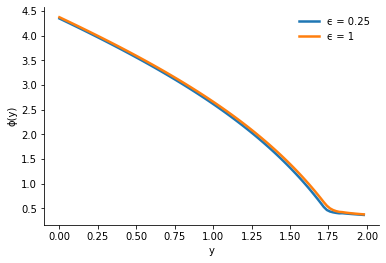

In [221]:
ep_list = [0.25, 1]
for i in range(len(r0_list)):
    plt.plot(y_grid_cap,solu_list[i]['φ'], label='ϵ = {}'.format(ep_list[i]))
# plt.ylim(0)
plt.legend()
plt.ylabel('ϕ(y)')
plt.xlabel('y')
# plt.savefig('../figures/interval_jump.pdf')

Text(0.5, 0, 'y')

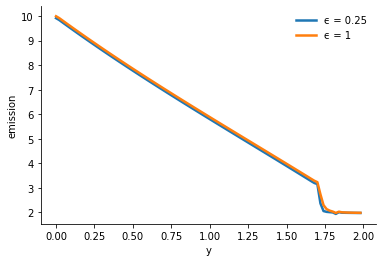

In [222]:
ep_list = [0.25, 1]
for i in range(len(r0_list)):
    plt.plot(y_grid_cap,solu_list[i]['ems'], label='ϵ = {}'.format(ep_list[i]))
# plt.ylim(0)
plt.legend()
plt.ylabel('emission')
plt.xlabel('y')
# plt.savefig('../figures/interval_jump.pdf')

In [223]:
def simulate_ems(y_grid_cap, ems, θ_list, y_start =1 , T=100):
    yt = np.zeros(T)
    et = np.zeros(T)
    y = y_start
    for t in range(T):
        e_i = np.interp(y, y_grid_cap, ems)
        et[t] = e_i
        yt[t] = y
        y = y + np.mean(θ_list)*e_i
    return yt, et

In [224]:
simul = []
for i in range(len(r0_list)):
    yt,et = simulate_ems(y_grid_cap, solu_list[i]['ems'], θ_list)
    simul.append(dict(et=et, yt=yt))

Text(0.5, 0, 'Years')

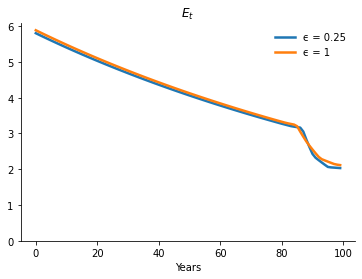

In [236]:
for i in range(len(r0_list)):
    plt.plot(simul[i]['et'], label='ϵ = {}'.format(ep_list[i]))
plt.legend()
plt.title('$E_t$')
plt.ylim(0)
plt.xlabel('Years')
# plt.savefig('../figures/ems_interval_jump.pdf')

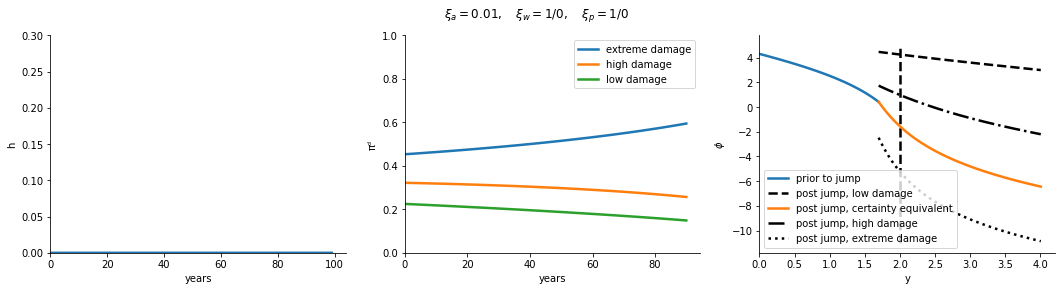

In [15]:
yt, et, πᵈt, πᶜt, ιt, ht = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list)
args_plot = (ξa, ξw, ξp, numy_bar, dmg_weight)
plot_solu(ht, πᵈt, ϕ_list, solu, args_plot)

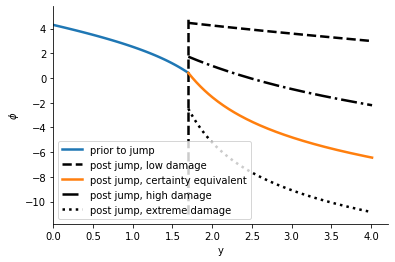

In [18]:
fig,ax3 = plt.subplots()
ϕ = solu["φ"]
ϕ_bound = np.average(np.exp(-1/ξp*ϕ_list), axis=0, weights=dmg_weight)
ϕ_bound = -ξp*np.log(ϕ_bound)
ax3.plot(y_grid[:numy_bar+1], ϕ, label='prior to jump')
ax3.plot(y_grid[numy_bar:], ϕ_list[0][numy_bar:], linestyle="--", color="black", label="post jump, low damage")
ax3.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:], label="post jump, certainty equivalent")
ax3.plot(y_grid[numy_bar:], ϕ_list[1][numy_bar:], linestyle="-.", color="black", label="post jump, high damage")
if np.count_nonzero(dmg_weight) > 2:
    ax3.plot(y_grid[numy_bar:], ϕ_list[-1][numy_bar:], linestyle=":", color="black", label="post jump, extreme damage")
ax3.vlines(x=ȳ, ymin=-11, ymax=5, linestyle="dashed", color="black")
# ax3.xlim(0,4)
# ax3.ylim(-0.02, 0.05)
ax3.set_ylabel('$\phi$')
ax3.set_xlabel('y')
ax3.set_xlim(left=0)
ax3.legend()

(0.0, 5.923642464027751)

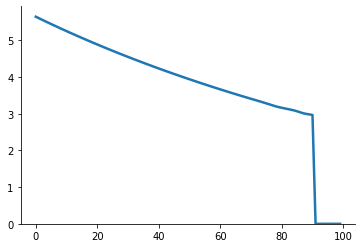

In [19]:
plt.plot(et)
plt.ylim(0)

In [41]:
from bokeh.plotting import figure
from bokeh.io import output_notebook,show
output_notebook()

Loading BokehJS ...

In [42]:
years = np.arange(0,100)
from bokeh.layouts import column


s1 = figure(
    title="Emission trajectories", 
    x_axis_label='Years',
    y_axis_label='Emission', 
    y_range=(0,0.3),
    plot_width=400, plot_height=400
)
s1.line(years, ht, line_color="navy")
s1.xgrid.grid_line_alpha=0.5


s2 = figure(
    title="Distorted probabilities of damages", 
    x_axis_label='Years', 
    y_axis_label='Emission', 
    plot_width=400, plot_height=400
)
s2.multi_line(
    xs = [years for i in range(3)], 
    ys=[πdt[:,i] for i in range(3)], 
    line_color=["darkgreen", "darkorange", "red"]
)

show(column(s1,s2))

In [50]:
πdt.shape

(100, 3)

Checkout another notebook:
[uncertainty decomposition](jump_damage_decompose_minimization_100.ipynb)

(0.8, 3.0)

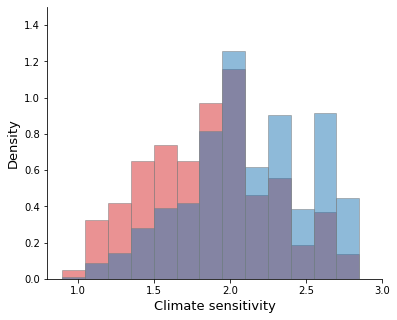

In [22]:
# histogram 10, 50, 90
from matplotlib.ticker import MaxNLocator
fig,ax2 = plt.subplots(1, 1,figsize=(6,5))
# ax1.hist(θ_list*1000, weights=πt_avg[10]*np.exp(-10*δ), density=True, bins=15, color='lightskyblue', ec="grey", alpha=0.8)
# ax1.set_xlabel('Climate sensitivity', fontsize=13)
# ax1.set_ylabel('Distorted density (year 10)', fontsize=13)

# ax1.hist(θ_list*1000, density=True, bins=15, color="salmon", ec="grey", alpha=0.6)
# ax1.set_xlabel('Climate sensitivity', fontsize=13)
# ax1.set_ylabel('Distorted density (year 10)', fontsize=13)
bins = np.linspace(0, 3, 21)

ax2.hist(θ_list*1000, bins=bins, color='tab:red', histtype='bar', ec='gray', alpha=.5, density=True)
ax2.hist(θ_list*1000, weights=πᶜt[50]*np.exp(-δ*50), bins=bins, color='tab:blue', histtype='bar', ec='gray', alpha=.5, density=True)
ax2.set_xlabel('Climate sensitivity', fontsize=13)
ax2.set_ylabel('Density', fontsize=13)
# ax2.set_title('Mean difference: {:.2f} '.format( (θ_list@πᶜt[50]-np.mean(θ_list) + σy*ht[50])*1000 ) )
ax2.set_ylim(0,1.5)
ax2.set_xticks(np.arange(0,3+0.5, 0.5))
ax2.set_xlim(0.8, 3)
# ax2.hist(θ_list*1000, weights=πᶜt[50]*np.exp(-50*δ), density=True, bins=np.linspace(1,3,14), color="tab:blue", ec="grey", alpha=0.5)
# ax2.set_xlabel('Climate sensitivity', fontsize=13)
# ax2.set_ylabel('Distorted density (year 50)', fontsize=13)
# ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
# ax2.hist(θ_list*1000, density=True, bins=np.linspace(1,3,14), color="tab:red", ec="grey", alpha=0.5)
# ax2.set_xlabel('Climate sensitivity', fontsize=13)
# ax2.set_ylabel('Distorted density (year 50)', fontsize=13)



# ax3.hist(θ_list*1000, weights=πt_avg[90]*np.exp(-90*δ), density=True, bins=15, color="lightskyblue", ec="grey", alpha=0.6)
# ax3.set_xlabel('Climate sensitivity', fontsize=13)
# ax3.set_ylabel('Distorted density (year 90)', fontsize=13)

# ax3.hist(θ_list*1000, density=True, bins=15, color="salmon", ec="grey", alpha=0.6)
# ax3.set_xlabel('Climate sensitivity', fontsize=13)
# ax3.set_ylabel('Distorted density (year 90)', fontsize=13)

# plt.savefig('./paper_plots/histogram_worstcase.pdf')

(0.8, 3.0)

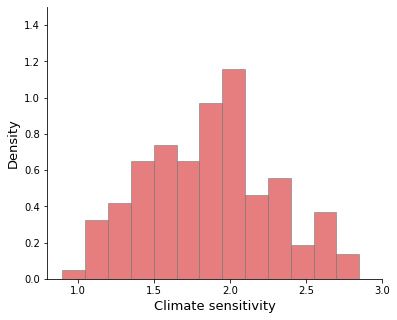

In [23]:
# histogram θ_list
fig,ax2 = plt.subplots(1, 1,figsize=(6,5))
# ax1.hist(θ_list*1000, weights=πt_avg[10]*np.exp(-10*δ), density=True, bins=15, color='lightskyblue', ec="grey", alpha=0.8)
# ax1.set_xlabel('Climate sensitivity', fontsize=13)
# ax1.set_ylabel('Distorted density (year 10)', fontsize=13)

# ax1.hist(θ_list*1000, density=True, bins=15, color="salmon", ec="grey", alpha=0.6)
# ax1.set_xlabel('Climate sensitivity', fontsize=13)
# ax1.set_ylabel('Distorted density (year 10)', fontsize=13)
bins = np.linspace(0, 3, 21)

ax2.hist(θ_list*1000, bins=bins, color='tab:red', histtype='bar', ec='gray', alpha=.6, density=True)
# ax2.hist(θ_list*1000, weights=πᶜt[50], bins=bins, color='tab:blue', histtype='bar', ec='darkgray', alpha=.5, density=True)
ax2.set_xlabel('Climate sensitivity', fontsize=13)
ax2.set_ylabel('Density', fontsize=13)
# ax2.set_title('Mean difference: {:.2f} '.format( (θ_list@πᶜt[50]-np.mean(θ_list) + σy*ht[50])*1000 ) )
ax2.set_ylim(0,1.5)
ax2.set_xticks(np.arange(0,3+0.5, 0.5))
ax2.set_xlim(0.8, 3)

# plt.savefig('./paper_plots/histogram.pdf')

In [12]:
# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt
def simulate_scc(invkap, αₖ,  σₖ, κ, k0, MEt, T=100, dt=1):
    Kt = simulate_logkapital(invkap, αₖ, σₖ, κ,  k0)
    MCt = δ*(1-η)/((α - invkap)*np.exp(Kt))
    Ct = (α - invkap)*np.exp(Kt)
    SCCt = MEt/MCt*1000
    return SCCt, Ct

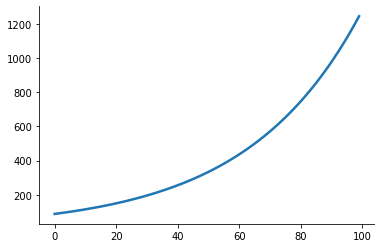

In [13]:
MEt = δ*η/et
SCCt, Ct = simulate_scc(invkap, αₖ,  σₖ, κ, k0, MEt)
plt.plot(SCCt)

In [14]:
ξa = 1/10_000*100
ξw = 1000*100
ξp = 1/20*100
args_unreveal = (δ, η, θ_list, σy, γ1, γ2, γ3_list, ȳ, ξa, ξw)
ϕ_unreveal, ems_unreveal, π_unreveal = solve_smooth_unreveal(y_grid, args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 694,	 ode error: 0.0008695666923007328,	 ft error: 9.965709146797508e-08


In [45]:
def simulate_unreveal(y_grid, ems, π, me, θ_list, y_start=1, T=100, dt=1):
    periods = int(T/dt)
    et = np.zeros(periods)
    yt = np.zeros(periods)
    πt = np.zeros((periods, len(π)))
    me_t = np.zeros(periods)
    get_π = interpolate.interp1d(y_grid, π)
#     y = np.mean(θ_list)*290
    y = y_start
    for t in range(periods):
        if y > np.max(y_grid):
            break
        else:
            ems_point = np.interp(y, y_grid, ems)
            π_list = get_π(y)
            if me is not None:
                me_point = np.interp(y, y_grid, me)
                me_t[t] = me_point
            et[t] = ems_point
            πt[t] = π_list
            
            yt[t] = y
            dy = ems_point*np.mean(θ_list)*dt
            y = dy + y
    
    return yt, et, πt, me_t

In [16]:
logKt = simulate_logkapital(invkap, αₖ,  σₖ, κ, k0,)

In [17]:
yt_unreveal, et_unreveal, πt_unreveal, _ = simulate_unreveal(y_grid, ems_unreveal, π_unreveal, None, θ_list, T=200)

Text(0.5, 1.0, 'Emission trajectories \n $\\xi_a = 0.01, ξ_p = 5$ for with threshold\n $ξ = 0.01$ for without threshold')

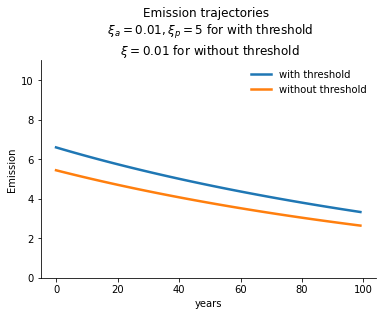

In [18]:
plt.plot(et[et>0], label="with threshold")
plt.plot(et_unreveal[:100], label="without threshold")
plt.ylim(0,11)
plt.legend(frameon=False)
plt.xlabel("years")
plt.ylabel("Emission")
plt.title("Emission trajectories \n $\\xi_a = 0.01, ξ_p = 5$ for with threshold\n $ξ = 0.01$ for without threshold")
# plt.savefig("./paper_plots/ems_nojumpcompare.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

Text(0.5, 1.0, '$Y_t$ trajectories \n $\\xi_a = 0.01, ξ_p = 5$ for with threshold\n $ξ = 0.01$ for without threshold')

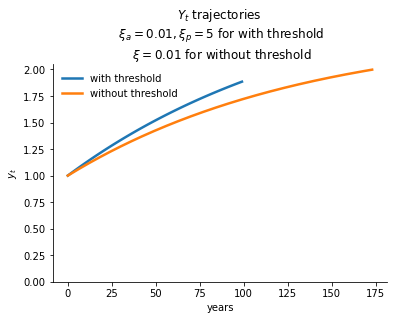

In [19]:
plt.plot(yt[yt>0], label="with threshold")
plt.plot(yt_unreveal[yt_unreveal<=2], label="without threshold")
plt.ylim(0)
plt.legend(frameon=False)
plt.xlabel("years")
plt.ylabel("$y_t$")
plt.title("$Y_t$ trajectories \n $\\xi_a = 0.01, ξ_p = 5$ for with threshold\n $ξ = 0.01$ for without threshold")
# plt.savefig("./paper_plots/ems_nojumpcompare.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

Text(0.5, 1.0, 'SCC \n $\\xi_a = 0.01, ξ_p = 5$ for with threshold\n $ξ = 0.01$ for without threshold')

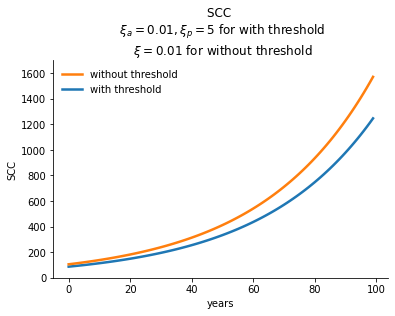

In [20]:
SCCt_unreveal = η*(α - invkap)*np.exp(logKt)/(1-η)/et_unreveal[:100]*1000
plt.plot(SCCt, label="with threshold")
plt.plot(SCCt_unreveal, label="without threshold")
plt.ylim(0,1700)
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
# plt.legend(frameon=False)
plt.xlabel("years")
plt.ylabel("SCC")
plt.title("SCC \n $\\xi_a = 0.01, ξ_p = 5$ for with threshold\n $ξ = 0.01$ for without threshold")
# plt.savefig("./paper_plots/scc_nojumpcompare.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

In [21]:
ξa = 1000*100
ξw = 1000*100
ξp = 1000*100
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one_100(y_grid, numy_bar, args,)
yt_base, et_base, πᵈt, πᶜt, ιt, ht = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list)

episode: 10000,	 ode error: 0.00011710457906673188,	 ft error: 0.00012173167466637362
episode: 5012,	 ode error: 0.000328243742822254,	 ft error: 9.970615444387931e-09
episode: 5377,	 ode error: 0.0011686487381849346,	 ft error: 9.996075078788635e-09
episode: 1227,	 ode error: 0.000521663011021703,	 ft error: 9.933103228831897e-09


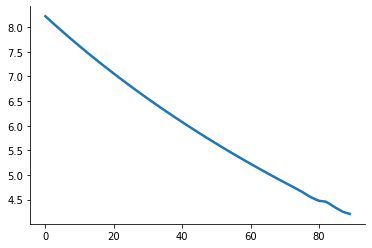

In [28]:
plt.plot(et_base[et_base>0])

In [22]:
ξa = 1000*100
args_unreveal = (δ, η, θ_list, σy, γ1, γ2, γ3_list, ȳ, ξa, ξw)
ϕ_unreveal_base, ems_unreveal_base, π_unreveal_base = solve_smooth_unreveal(y_grid, args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 681,	 ode error: 0.000652568780844253,	 ft error: 9.846339643626578e-08


In [25]:
yt_unreveal_base, et_unreveal_base, πt_unreveal_base, _ = simulate_unreveal(y_grid, ems_unreveal_base, π_unreveal_base, None, θ_list, T=200)

Text(0.5, 1.0, 'Emission trajectories \n $ξ_a = \\infty, ξ_p = \\infty$ for with jump\n $ξ =\\infty$ for without jump')

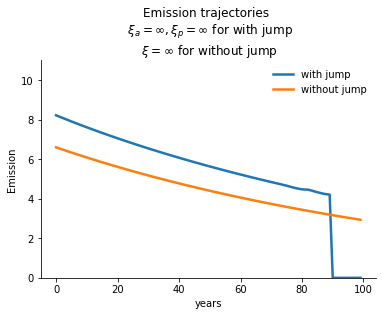

In [26]:
plt.plot(et_base, label="with jump")
plt.plot(et_unreveal_base[:100], label="without jump")
plt.ylim(0,11)
plt.legend(frameon=False)
plt.xlabel("years")
plt.ylabel("Emission")
plt.title("Emission trajectories \n $ξ_a = \infty, ξ_p = \infty$ for with jump\n $ξ =\infty$ for without jump")
# plt.savefig("./paper_plots/ems_nojumpcompare_base.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

<ipython-input-31-e599f94ff8f7>:1: RuntimeWarning: divide by zero encountered in true_divide
  SCCt_base = η*(α - invkap)*np.exp(logKt)/(1-η)/et_base*1000


Text(0.5, 1.0, 'SCC \n $ξ_a = \\infty, ξ_p = \\infty$ for with jump\n $ξ = \\infty$ for without jump')

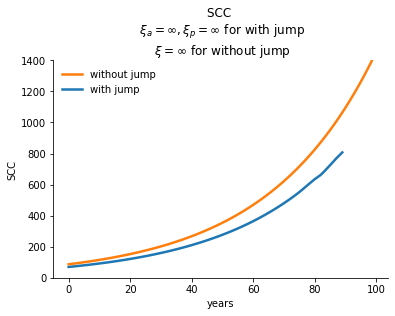

In [31]:
SCCt_base = η*(α - invkap)*np.exp(logKt)/(1-η)/et_base*1000
SCCt_unreveal_base = η*(α - invkap)*np.exp(logKt)/(1-η)/et_unreveal_base[:100]*1000
plt.plot(SCCt_base, label="with jump")
plt.plot(SCCt_unreveal_base, label="without jump")
plt.ylim(0,1400)
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
# plt.legend(frameon=False)
plt.xlabel("years")
plt.ylabel("SCC")
plt.title("SCC \n $ξ_a = \infty, ξ_p = \infty$ for with jump\n $ξ = \infty$ for without jump")
# plt.savefig("./paper_plots/scc_nojumpcompare_base.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

In [33]:
n_climate = len(θ_list)
n_dmg = len(γ3_list)
πc_dict = dict()
for year in [10,50,90, -1]:
    πc_dict[year] = np.sum(πt_unreveal[year].reshape(n_climate, n_dmg), axis=1)

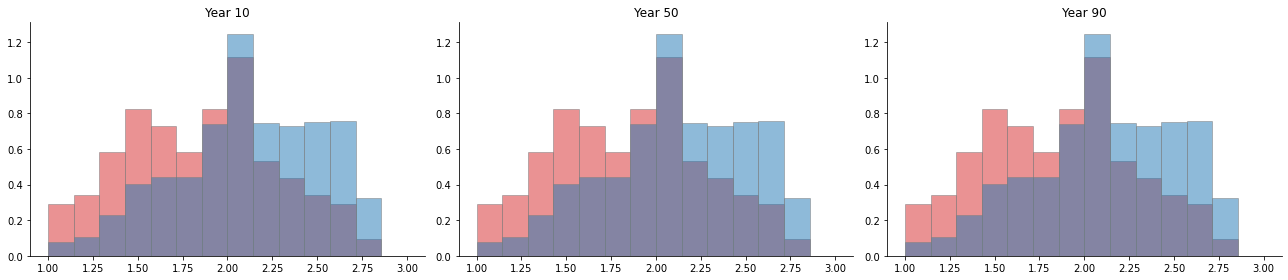

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))
axes = [ax1, ax2, ax3]
bins=np.linspace(1,3,15)
ax1.set_title("Year 10")
ax1.hist(θ_list*1000, density=True, bins=bins, alpha=0.5, ec="gray", color="tab:red" )
ax1.hist(θ_list*1000, weights=πc_dict[10], bins=bins, density=True, alpha=0.5, ec="gray", color="tab:blue")

ax2.set_title("Year 50")
ax2.hist(θ_list*1000, density=True, bins=bins, alpha=0.5, ec="gray",color="tab:red" )
ax2.hist(θ_list*1000, weights=πc_dict[50]*np.exp(-50*δ), bins=bins, density=True, alpha=0.5, ec="gray",color="tab:blue")

ax3.set_title("Year 90")
ax3.hist(θ_list*1000, density=True, bins=bins, alpha=0.5, ec="gray", color="tab:red" )
ax3.hist(θ_list*1000, weights=πc_dict[90]*np.exp(-90*δ), bins=bins, density=True, alpha=0.5, ec="gray", color="tab:blue")

fig.tight_layout()
# fig.savefig("./paper_plots/hist_time.png", facecolor="w",dpi=500)

In [35]:
πd_list = np.zeros((200,3))
for year in range(200):
    πd_list[year] = np.sum(πt_unreveal[year].reshape(n_climate, n_dmg), axis=0)

# Decompose  for no jump version

In [36]:
def solve_smooth_unreveal_decompose(y_grid, ems_star, args, max_iter, tol, ϵ,):
    """
    solve for step one, ϕⱼ for individual damage function
    
    Parameter
    ---
    args: δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξa, ξw
    """
    δ, η, θ_list, σy, γ1, γ2, γ3_list, ȳ, ξa, ξw = args
    params = list()
    for θ_i in θ_list:
        for γ3 in γ3_list:
            params.append([θ_i, γ3])
    params = np.array(params)
    θ_long = params[:,0]
    γ3_long = params[:,1]
    args_weight = (δ, η, γ1, γ2, ȳ, σy, ξa)
    dy = y_grid[1] - y_grid[0]
    n_y = len(y_grid)
#     dΛ = γ1 + γ2*y_grid + γ3*(y_grid-ȳ)*(y_grid>ȳ)
#     ddΛ = γ2 + γ3*(y_grid>ȳ)
    ϕ = - η*y_grid**2
    ems = η
    ems_old = ems
    πo = np.ones((len(params), n_y))/len(params)
    lhs_error = 1
    episode = 0
    while lhs_error > tol and episode < max_iter:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, dy, "up")
        dϕdyy = derivative_1d(ϕ, 2, dy, "up")
#         temp1 = dϕdy + (η-1)/δ*dΛ
#         temp2 = dϕdyy + (de)
        # update belief
        weight = generate_weight(params, ems_star, dϕdy, y_grid, args_weight)
        π = πo*np.exp(weight)
        π[π <= 1e-15] = 1e-15
        π = π/np.sum(π, axis=0)
        # update control
#         temp = dϕdy + (η-1)/δ*(γ1 + γ2*y_grid)
#         ddΛ = γ2 + γ3_long@π*(y_grid>ȳ)
#         a = (dϕdyy  + (η-1)/δ*ddΛ)*σy**2
#         b = (θ_long@π)*temp + (η-1)/δ*((θ_long*γ3_long)@π)*(y_grid - ȳ)*(y_grid>ȳ)
#         c = η
#         Δ = b**2 - 4*a*c
#         Δ[Δ < 0] = 0
#         root1 = (-b - np.sqrt(Δ))/(2*a)
#         root2 = (-b + np.sqrt(Δ))/(2*a)
#         if root1.all() > 0:
#             ems_new = root1
#         else:
#             ems_new = root2
#         ems_new[ems_new < 1e-15] = 1e-15
#         ems = ems_new*0.5 + ems_old*0.5
        # solve for ode
        dmg_drift = θ_long@π*(γ1 + γ2*y_grid)*ems_star + (θ_long*γ3_long)@π*(y_grid-ȳ)*(y_grid>ȳ)*ems_star\
        + 1/2*(γ3_long@π)*(y_grid>ȳ)*σy**2*ems_star**2 + 1/2*γ2*σy**2*ems_star**2
        A = - δ*np.ones(y_grid.shape)
        B = (θ_long@π)*ems_star
#         C = np.zeros(y_grid.shape)
        C = ems_star**2*σy**2/2
        D = η*np.log(ems_star) + ξa*np.sum(π*(np.log(π) - np.log(πo)), axis=0)\
            + (η-1)/δ*dmg_drift
#         - 1/(2*ξw)*temp**2*ems**2*σy**2\
#         + 1/2*(η-1)/δ*ddΛ*ems**2*σy**2
        ϕ_new = solve_ode(A, B, C, D, y_grid, ϕ, ϵ, (False, 0))
        rhs = -δ*ϕ_new + B*dϕdy + C*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
#         ems_old = ems
        episode += 1
    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))
    me = - θ_long@π*(dϕdy + (η-1)/δ*(γ1 + γ2*y_grid)) - (η-1)/δ*(θ_long*γ3_long)@π*(y_grid-ȳ)*(y_grid>ȳ) \
        - (η-1)/δ*(γ3_long@π)*(y_grid>ȳ)*σy**2*ems_star - (η-1)/δ*γ2*σy**2*ems_star - dϕdyy*σy**2*ems_star
#     h = - temp*ems*σy/ξw
    return ϕ, ems, π, me

In [37]:
ξa = 1/100
args_unreveal = (δ, η, θ_list, σy, γ1, γ2, γ3_list, ȳ, ξa, ξw)
ϕ_test, ems_test, π_test, me_unreveal = solve_smooth_unreveal_decompose(y_grid, ems_unreveal, args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 694,	 ode error: 0.0008695669350341304,	 ft error: 9.959527069725027e-08


In [38]:
ems_10 = 10*np.ones(ems_unreveal.shape)

In [39]:
ems = ems_unreveal
# ems = ems_10

In [44]:
# base
ξa = 1000*100
args_unreveal = (δ, η, θ_list, σy, γ1, γ2, γ3_list, ȳ, ξa, ξw)
ϕ_b, ems_b, π_b, me_b = solve_smooth_unreveal_decompose(y_grid, ems, args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 681,	 ode error: 0.0005883286089622009,	 ft error: 9.537113232482852e-08


In [45]:
# dmamage 
ξa = 1/100
args_unreveal = (δ, η, [np.average(θ_list)], σy, γ1, γ2, γ3_list, ȳ, ξa, ξw)
ϕ_dmg, ems_dmg, π_dmg, me_dmg = solve_smooth_unreveal_decompose(y_grid, ems, args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 5000,	 ode error: 0.0007692703380716287,	 ft error: 2.826561062840849e-05


In [46]:
# temp
ξa = 1/100
args_unreveal = (δ, η, θtemp_list, σy, γ1, γ2, [np.average(γ3_list)], ȳ, ξa, ξw)
ϕ_temp, ems_temp, π_temp, me_temp = solve_smooth_unreveal_decompose(y_grid, ems, args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 688,	 ode error: 0.0006117452360071673,	 ft error: 9.824843516526016e-08


In [47]:
# carb
ξa = 1/100
args_unreveal = (δ, η, θcarb_list, σy, γ1, γ2, [np.average(γ3_list)], ȳ, ξa, ξw)
ϕ_carb, ems_carb, π_carb, me_carb = solve_smooth_unreveal_decompose(y_grid, ems, args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 687,	 ode error: 0.0005965204360334053,	 ft error: 9.99169396109778e-08


In [48]:
# total
ξa = 1/100
args_unreveal = (δ, η, θ_list, σy, γ1, γ2, γ3_list, ȳ, ξa, ξw)
ϕ_total, ems_total, π_total, me_total = solve_smooth_unreveal_decompose(y_grid, ems, args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 694,	 ode error: 0.0008695669350341304,	 ft error: 9.959527069725027e-08


In [49]:
yt_b, et_b, πt_b, met_b = simulate_unreveal(y_grid, ems, π_b, me_b, θ_list, T=200)
yt_dmg, et_dmg, πt_dmg, met_dmg = simulate_unreveal(y_grid, ems, π_dmg, me_dmg, θ_list, T=200)
yt_temp, et_temp, πt_temp, met_temp = simulate_unreveal(y_grid, ems, π_temp, me_temp, θ_list, T=200)
yt_carb, et_carb, πt_carb, met_carb = simulate_unreveal(y_grid, ems, π_carb, me_carb, θ_list, T=200)
yt_total, et_total, πt_total, met_total = simulate_unreveal(y_grid, ems, π_total, me_total, θ_list, T=200)

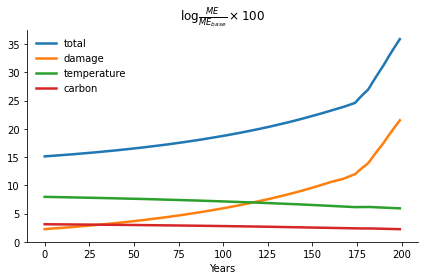

In [50]:
plt.plot(np.log(met_total/met_b)*100, label="total")
plt.plot(np.log(met_dmg/met_b)*100, label="damage")
plt.plot(np.log(met_temp/met_b)*100, label="temperature")
plt.plot(np.log(met_carb/met_b)*100, label="carbon")
plt.ylim(0)
plt.xlabel("Years")
plt.legend(frameon=False)
plt.title("$\\log \\frac{ME}{ME_{base}} \\times 100$")
plt.tight_layout()
# plt.savefig("./paper_plots/decomp_1type_21.png", dpi=500, facecolor="w")

Text(0.5, 1.0, '$\\log \\frac{ME}{ME_{base}} \\times 100$')

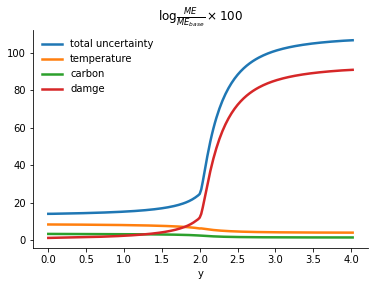

In [51]:
plt.plot(y_grid, np.log(me_total/me_b)*100, label="total uncertainty")
plt.plot(y_grid, np.log(me_temp/me_b)*100, label="temperature")
plt.plot(y_grid, np.log(me_carb/me_b)*100, label="carbon")
plt.plot(y_grid, np.log(me_dmg/me_b)*100, label="damge")
plt.xlabel("y")
plt.legend(frameon=False)
plt.title("$\\log \\frac{ME}{ME_{base}} \\times 100$")

In [52]:
# dmamage and temp
ξa = 1/100
args_unreveal = (δ, η, θtemp_list, σy, γ1, γ2, γ3_list, ȳ, ξa, ξw)
ϕ_tempdmg, ems_tempdmg, π_tempdmg, me_tempdmg = solve_smooth_unreveal_decompose(y_grid, ems, 
                                                                                args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 694,	 ode error: 0.0008360410378625491,	 ft error: 9.874248796393204e-08


In [53]:
# dmamage and carb
ξa = 1/100
args_unreveal = (δ, η, θcarb_list, σy, γ1, γ2, γ3_list, ȳ, ξa, ξw)
ϕ_carbdmg, ems_carbdmg, π_carbdmg, me_carbdmg = solve_smooth_unreveal_decompose(y_grid, ems, 
                                                                                args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 693,	 ode error: 0.0007965239294456961,	 ft error: 9.950145329895577e-08


In [54]:
# temp and carb
ξa = 1/100
args_unreveal = (δ, η, θ_list, σy, γ1, γ2, [np.average(γ3_list)], ȳ, ξa, ξw)
ϕ_tempcarb, ems_tempcarb, π_tempcarb, me_tempcarb = solve_smooth_unreveal_decompose(y_grid, ems, 
                                                                                    args_unreveal, 
                                                             max_iter=5000, tol=1e-7, ϵ=2,)

episode: 688,	 ode error: 0.0006244045825355357,	 ft error: 9.841302439639321e-08


In [55]:
yt_carbdmg, et_carbdmg, πt_carbdmg, met_carbdmg = simulate_unreveal(y_grid, ems, π_carbdmg, me_carbdmg, θ_list, T=200)
yt_tempcarb, et_tempcarb, πt_tempcarb, met_tempcarb = simulate_unreveal(y_grid, ems, π_tempcarb, me_tempcarb, θ_list, T=200)
yt_tempdmg, et_tempdmg, πt_tempdmg, met_tempdmg = simulate_unreveal(y_grid, ems, π_tempdmg, me_tempdmg, θ_list, T=200)

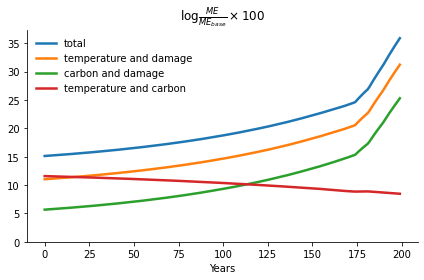

In [56]:
plt.plot(np.log(met_total/met_b)*100, label="total")
plt.plot(np.log(met_tempdmg/met_b)*100, label="temperature and damage")
plt.plot(np.log(met_carbdmg/met_b)*100, label="carbon and damage")
plt.plot(np.log(met_tempcarb/met_b)*100, label="temperature and carbon")
# plt.plot(np.log(met_tempcarb/met_b)*100, label="temperature and carbon"))
plt.ylim(0)
plt.xlabel("Years")
plt.legend(frameon=False)
plt.title("$\\log \\frac{ME}{ME_{base}} \\times 100$")
plt.tight_layout()
# plt.savefig("./paper_plots/decomp_2type_21.png", facecolor="w", dpi=500)

Text(0.5, 1.0, '$\\log \\frac{ME}{ME_{base}} \\times 100$')

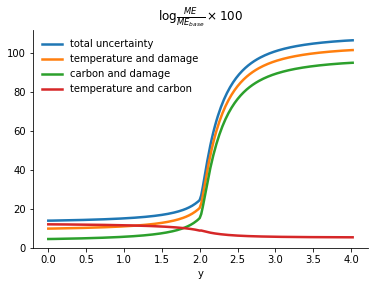

In [57]:
plt.plot(y_grid, np.log(me_total/me_b)*100, label="total uncertainty")
plt.plot(y_grid, np.log(me_tempdmg/me_b)*100, label="temperature and damage")
plt.plot(y_grid, np.log(me_carbdmg/me_b)*100, label="carbon and damage")
plt.plot(y_grid, np.log(me_tempcarb/me_b)*100, label="temperature and carbon")
plt.xlabel("y")
plt.ylim(0)
plt.legend(frameon=False)
plt.title("$\\log \\frac{ME}{ME_{base}} \\times 100$")

# SCC uncertainty decomposition: pre jump

First order condition for $\tilde e$

$$
    \left( \frac{d^2\phi(y)}{dy^2} + \frac{(\eta-1)}{\delta}\cdot\gamma_2  \right)|\sigma_y|^2\tilde e + \sum_j \pi^c_j \left[\frac{d\phi(y)}{dy} + \frac{(\eta - 1)}{\delta}(\gamma_1 + \gamma_2 y)\right]\theta_j  + \frac{\eta}{\tilde e} = 0 \tag{$\ast$}
$$

Call solution $\tilde e^* $. Now solve:
$$
\begin{aligned}
0 =  & - \delta \color{red}{\phi(y)}+ \eta \log\tilde e^* + \frac{1}{2} \color{red}{ \frac{d^2 \phi}{dy^2}}\cdot(\tilde e^*)^2 |\sigma_y|^2 + \frac{1}{2}\frac{(\eta -1)}{\delta}\gamma_2(\tilde e^*)^2 |\sigma_y|^2\\
& + \left[\color{red}{\frac{d\phi}{dy}}  + \frac{(\eta -1)}{\delta}(\gamma_1 + \gamma_2 y)\right] \tilde e^* \sum_i \pi_i^c \theta_i
\end{aligned}
$$

In [58]:
def plot_together(et, θ_list, ht, πᶜt, πᵈt, MEt, dmg_weight):
    y_grid_cap = y_grid[:numy_bar+1]
    πᶜo = πᶜo = np.ones(len(θ_list))/len(θ_list)
    # plot
    fig,((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12,8))
    fig.tight_layout(pad=5)
    # plot 1
    if np.count_nonzero(dmg_weight) > 2:
        ax1.plot(πᵈt[:,-1], label="extreme damage", color="C2")
    ax1.plot(πᵈt[:,1], label="high damage", color="C3")
    ax1.plot(πᵈt[:,0], label="low", color="C0")
    ax1.legend(frameon=False)
    ax1.set_xlabel('Years')
    ax1.set_ylim(0,1)
    ax1.set_xlim(left=0)
    ax1.set_title('distorted probability of damage')
    # plot 2
    bins = np.linspace(1,3,14)
    ax2.hist(θ_list*1000, density=True, color='tab:red', bins=bins, histtype='bar', ec='gray', alpha=.5, )
    ax2.hist((θ_list+σy*ht[49])*1000, weights=πᶜt[49], density=True, color='tab:blue',bins=bins, histtype='bar', ec='gray', alpha=.5,)
    ax2.set_title('mean difference: {:.4f}'.format((θ_list@(πᶜt[49]-πᶜo)+σy*ht[49])*1000))
    ax2.set_xlabel('Climate sensitivity, year 50')
    ax2.set_xlim(0.8,3)
    # plot 3
    ax3.plot(et[et_base>0],label='distorted', color="C3")
    ax3.plot(et_base[et_base>0], label="baseline", color="C0")
    ax3.legend(frameon=False)
    ax3.set_xlabel('Years')
    ax3.set_ylim(bottom=0)
    ax3.set_xlim(left=0)
    ax3.set_title('emission')
    # plot 4
    SCCt_base, _ = simulate_scc(invkap, αₖ,  σₖ, κ, k0, MEt)
    SCCt_distorted, _ = simulate_scc(invkap, αₖ,  σₖ, κ, k0, δ*η/et)
#     ax4.plot((δ*η/et[et>0])/MC[et>0]*1000, label="total", color="C3")
    ax4.plot(SCCt_distorted, label="total", color="C3")
#     ax4.plot((ME/MC)[et>0]*1000, label="baseline", color="C0")
    ax4.plot(SCCt_distorted - SCCt_base, label="baseline", color="C0")
    ax4.legend(frameon=False)
    ax4.set_xlabel('Years')
    ax4.set_ylim(bottom=0)
    ax4.set_xlim(left=0)
    ax4.set_title('social cost of carbon')
    
    return fig, ((ax1, ax2), (ax3, ax4))

In [59]:
def simulate_jump_ems(y_grid, solu, ME,  θ_list, T=100, dt=1):
    ems = solu["ems"]
    πᶜ = solu["πc"]
    πᵈ = solu["πd"]
    ι = solu["ι"]
    h = solu["h"]
    periods = int(T/dt)
    et = np.zeros(periods)
    yt = np.zeros(periods)
    πᶜt = np.zeros((periods, len(θ_list)))
    πᵈt = np.zeros((periods, len(πᵈ)))
    ιt = np.zeros(periods)
    ht = np.zeros(periods)
    if ME is not None:
        me_t = np.zeros(periods)
    # interpolate
    get_πᵈ = interpolate.interp1d(y_grid, πᵈ)
    get_πᶜ = interpolate.interp1d(y_grid, πᶜ)
#     y = np.mean(θ_list)*290
    y=1
    for t in range(periods):
        if y > np.max(y_grid):
            break
        else:
            ems_point = np.interp(y, y_grid, ems)
            πᵈ_list = get_πᵈ(y)
            πᶜ_list = get_πᶜ(y)
            ι_point = np.interp(y, y_grid, ι)
            h_point = np.interp(y, y_grid, h)
            if ME is not None:
                me_point = np.interp(y, y_grid, ME)
                me_t[t] = me_point
            et[t] = ems_point
            πᵈt[t] = πᵈ_list
            πᶜt[t] = πᶜ_list
            ιt[t] = ι_point
            ht[t] = h_point
            yt[t] = y
            dy = ems_point*(θ_list@πᶜ_list + σy*h_point)*dt
            y = dy + y
    if ME is not None:
        return yt, et, πᵈt, πᶜt, ιt, ht, me_t
    else:
        return yt, et, πᵈt, πᶜt, ιt, ht

In [154]:
ξa = 100000
ξw = 100000
ξp = 100000
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one_100(y_grid, numy_bar, args, ϵ=3, max_iter=5000)
yt_bb, et_bb, πᵈt, πᶜt, ιt, ht = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list)
yt_bbw, et_bbw, πᵈt, πᶜt, ιt, ht = simulate_jump_ems(y_grid[:numy_bar+1], solu, None, θ_list)

episode: 5000,	 ode error: 7.325914529324185e-05,	 ft error: 1.8219840886383547e-06
episode: 5000,	 ode error: 0.00023532655471273506,	 ft error: 4.188143125401685e-05
episode: 5000,	 ode error: 0.0011036955102757809,	 ft error: 2.729011709945439e-07
episode: 5000,	 ode error: 0.0005675509551250346,	 ft error: 5.34225959617866e-06


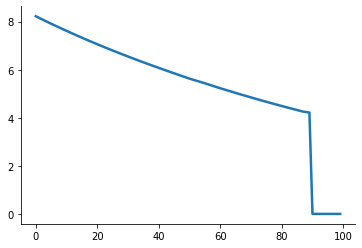

In [155]:
plt.plot(et_bb)

In [138]:
ξa = 100000
ξw = 0.3
ξp = 5
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one_100(y_grid, numy_bar, args, max_iter=5_000)
yt_3, et_3, πᵈt, πᶜt_3, ιt, ht_3 = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list)
yt_3w, et_3w, πᵈt, πᶜt_3, ιt, ht_3w = simulate_jump_ems(y_grid[:numy_bar+1], solu, None, θ_list)

episode: 5000,	 ode error: 0.0005104346301074425,	 ft error: 2.3678546477630867e-05
episode: 5000,	 ode error: 0.00023846874503928583,	 ft error: 0.00010943308729268372
episode: 5000,	 ode error: 0.000987460360670117,	 ft error: 3.1945338226554064e-08
episode: 1474,	 ode error: 0.0006519126084000362,	 ft error: 9.824745461628481e-09


In [139]:
# adding equal version 1 
ξa = 100000
ξw = 0.3
ξp = 0.3
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one_100(y_grid, numy_bar, args, ϵ=2, max_iter=5_000)
yt_e1, et_e1, πᵈt, πᶜt, ιt, ht_e1 = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list,)
yt_e1w, et_e1w, πᵈt, πᶜt, ιt, ht_e1w = simulate_jump_ems(y_grid[:numy_bar+1], solu, None, θ_list)

episode: 5000,	 ode error: 5.814652399450948e-05,	 ft error: 1.9997413803984898e-05
episode: 760,	 ode error: 0.0002837755205893633,	 ft error: 9.97730731366886e-09
episode: 817,	 ode error: 0.0009680955968403412,	 ft error: 9.804258738199678e-09
episode: 5000,	 ode error: 0.001879725126314011,	 ft error: 6.641312343402817e-07


In [140]:
# adding equal version 2
ξa = 1000*100
ξw = 1/20*100
ξp = 1/20*100
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one_100(y_grid, numy_bar, args, ϵ=2, max_iter=5_000)
yt_e2, et_e2, πᵈt, πᶜt, ιt, ht_e2 = simulate_jump(y_grid[:numy_bar+1], solu, None, θ_list,)
yt_e2w, et_e2w, πᵈt, πᶜt, ιt, ht_e2w = simulate_jump_ems(y_grid[:numy_bar+1], solu, None, θ_list)

episode: 3177,	 ode error: 8.894208216329857e-05,	 ft error: 9.778538423432792e-09
episode: 5000,	 ode error: 0.000241901747241903,	 ft error: 5.0170904475344e-05
episode: 814,	 ode error: 0.0010729152681469697,	 ft error: 9.739547834897166e-09
episode: 5000,	 ode error: 0.0007893408641111016,	 ft error: 4.773217333498003e-06


Text(0.5, 0, 'Years')

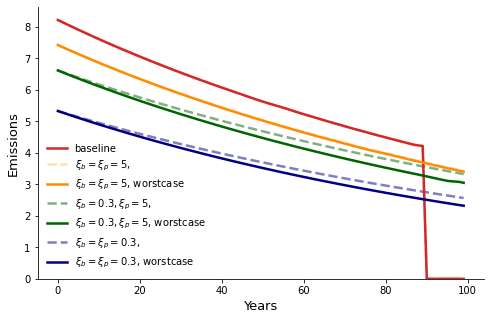

In [156]:
#
dt=1
years = np.arange(0,100,dt)
fig = plt.figure(figsize=(8,5))
plt.plot(years, et_bb, label="baseline", color="tab:red", alpha=0.3, linestyle="dashed")
plt.plot(years, et_e2, label="$ξ_b = ξ_p = 5$,", color="darkorange", alpha=0.3, linestyle="dashed")
# plt.plot(et_brownian, label="brownian robust, jump robust", color="tab:blue")
# plt.plot(et_smooth, label="smooth ambiguity, jump robust", color="darkgreen")
plt.plot(years, et_3, label="$ξ_b =0.3,  ξ_p = 5$,", color="darkgreen", alpha=0.5, linestyle="dashed")
plt.plot(years, et_e1, label="$ξ_b = ξ_p = 0.3$, " , color="navy", alpha=0.5, linestyle="dashed")


plt.plot(et_bbw, label="baseline", color="tab:red")
plt.plot(et_e2w, label="$ξ_b = ξ_p = 5$, worstcase", color="darkorange")
# plt.plot(et_brownian, label="brownian robust, jump robust", color="tab:blue")
# plt.plot(et_smooth, label="smooth ambiguity, jump robust", color="darkgreen")
plt.plot(et_3w, label="$ξ_b =0.3,  ξ_p = 5$, worstcase", color="darkgreen")
plt.plot(et_e1w, label="$ξ_b = ξ_p = 0.3$, worstcase" , color="navy")


# plt.plot(et, label="with drift term + jump robust")
handles, labels = plt.gca().get_legend_handles_labels()
order = [4,1,5,2,6,3,7,]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False, loc=3)
# plt.legend(frameon=False, loc=3)
plt.ylim(0)
plt.ylabel('Emissions', fontsize=13)
plt.xlabel('Years', fontsize=13)
# plt.savefig("./paper_plots/emission_three.pdf")
# plt.savefig("./paper_plots/emission.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

Text(0.5, 0, 'Years')

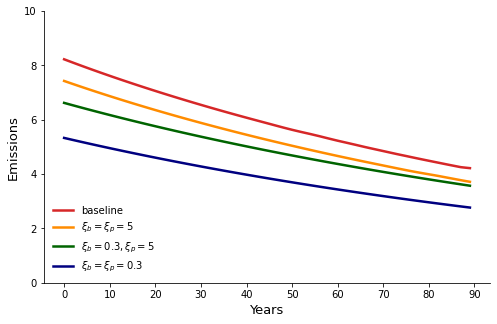

In [157]:
#
fig = plt.figure(figsize=(8,5))
plt.plot(years[et_bb>0], et_bb[et_bb>0], label="baseline", color="tab:red")
plt.plot(years[et_bb>0], et_e2[et_bb>0], label="$ξ_b = ξ_p = 5$", color="darkorange")
# plt.plot(et_brownian, label="brownian robust, jump robust", color="tab:blue")
# plt.plot(et_smooth, label="smooth ambiguity, jump robust", color="darkgreen")
plt.plot(years[et_bb>0], et_3[et_bb>0], label="$ξ_b =0.3,  ξ_p = 5$", color="darkgreen")
plt.plot(years[et_bb>0], et_e1[et_bb>0], label="$ξ_b = ξ_p = 0.3$" , color="navy")

# plt.plot(et, label="with drift term + jump robust")
plt.legend(frameon=False, loc=3)
plt.ylim(0,10)
# plt.xlim(right=95)
plt.xticks(np.arange(0, 91, 10))
plt.ylabel('Emissions', fontsize=13)
plt.xlabel('Years', fontsize=13)
# plt.savefig("./paper_plots/emission_three.pdf")
# plt.savefig("./paper_plots/emission_five.png", facecolor="w", edgecolor="w", bbox_inches="tight")

<ipython-input-147-07b4531d649b>:11: RuntimeWarning: divide by zero encountered in log
  plt.plot(years, np.log(1000) + np.log(Ct[0])  - (yt_bb*γ1 + γ2/2*yt_bb**2) -np.log(et_bb) + np.log(η) - np.log(1- η), label="baseline", color="tab:red")


Text(0.5, 0, 'Years')

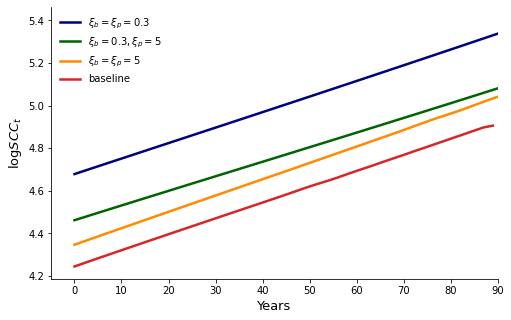

In [147]:
#
fig = plt.figure(figsize=(8,5))
# plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_browian*γ1 + γ2/2*yt_browian**2) - np.log(et_brownian) + np.log(η) - np.log(1 -η), label="brownian robust, jump robust", color="tab:blue")
# plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_smooth*γ1 + γ2/2*yt_smooth**2) - np.log(et_smooth) + np.log(η) - np.log(1 -η), label="smooth ambiguity, jump robust", color="darkgreen")


plt.plot(years, np.log(1000) + np.log(Ct[0])  - (yt_e1*γ1 + γ2/2*yt_e1**2) -np.log(et_e1) + np.log(η) - np.log(1- η), label="$ξ_b = ξ_p = 0.3$", color="navy")
plt.plot(years, np.log(1000) + np.log(Ct[0])  - (yt_3*γ1 + γ2/2*yt_3**2) -np.log(et_3) + np.log(η) - np.log(1- η), label="$ξ_b =0.3, ξ_p = 5$", color="darkgreen")
# plt.plot( np.log(1000) - np.log(et) + np.log(η) - np.log(1 -η), label="with drift term + jump robust")
plt.plot(years, np.log(1000) + np.log(Ct[0])  - (yt_e2*γ1 + γ2/2*yt_e2**2) -np.log(et_e2) + np.log(η) - np.log(1- η), label="$ξ_b = ξ_p = 5$", color="darkorange")
plt.plot(years, np.log(1000) + np.log(Ct[0])  - (yt_bb*γ1 + γ2/2*yt_bb**2) -np.log(et_bb) + np.log(η) - np.log(1- η), label="baseline", color="tab:red")
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
# plt.legend(frameon=False)
# plt.ylim(0)
plt.xticks(np.arange(0,91,10))
plt.xlim(right=90)
plt.ylabel('$\log SCC_t$', fontsize=13)
plt.xlabel('Years', fontsize=13)
# plt.title('$ \log(1000) -\log{\mathcal{E}_t} + \log \eta  - \log (1 - \eta)$')
# plt.savefig("./paper_plots/logscc.pdf")
# plt.savefig("./paper_plots/logscc_five.png", facecolor="w", edgecolor="w", bbox_inches="tight")

<ipython-input-130-90203d04de5d>:8: RuntimeWarning: divide by zero encountered in log
  plt.plot(years, np.log(1000) + np.log(Ct[0])  - (yt_bb*γ1 + γ2/2*yt_bb**2) -np.log(et_bb) + np.log(η) - np.log(1- η), label="baseline, baseline", color="tab:red", alpha=0.5, linestyle="dashed")
<ipython-input-130-90203d04de5d>:14: RuntimeWarning: divide by zero encountered in log
  plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_bbw*γ1 + γ2/2*yt_bbw**2) -np.log(et_bbw) + np.log(η) - np.log(1- η), label="baseline", color="tab:red")


Text(0.5, 0, 'Years')

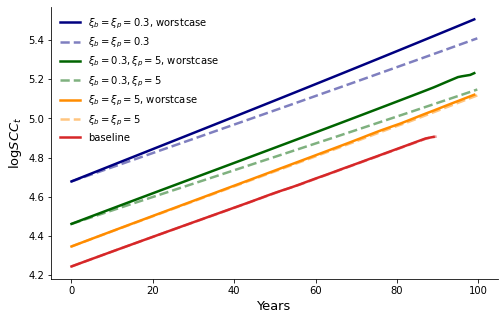

In [130]:
#
fig = plt.figure(figsize=(8,5))

plt.plot(years, np.log(1000) + np.log(Ct[0])  - (yt_e1*γ1 + γ2/2*yt_e1**2) -np.log(et_e1) + np.log(η) - np.log(1- η), label="$ξ_b = ξ_p = 0.3$", color="navy", alpha=0.5, linestyle="dashed")
plt.plot(years, np.log(1000) + np.log(Ct[0])  - (yt_3*γ1 + γ2/2*yt_3**2) -np.log(et_3) + np.log(η) - np.log(1- η), label="$ξ_b =0.3, ξ_p = 5$", color="darkgreen", alpha=0.5, linestyle="dashed")
# plt.plot( np.log(1000) - np.log(et) + np.log(η) - np.log(1 -η), label="with drift term + jump robust")
plt.plot(years, np.log(1000) + np.log(Ct[0])  - (yt_e2*γ1 + γ2/2*yt_e2**2) -np.log(et_e2) + np.log(η) - np.log(1- η), label="$ξ_b = ξ_p = 5$", color="darkorange", alpha=0.5, linestyle="dashed")
plt.plot(years, np.log(1000) + np.log(Ct[0])  - (yt_bb*γ1 + γ2/2*yt_bb**2) -np.log(et_bb) + np.log(η) - np.log(1- η), label="baseline, baseline", color="tab:red", alpha=0.5, linestyle="dashed")

plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_e1w*γ1 + γ2/2*yt_e1w**2) -np.log(et_e1w) + np.log(η) - np.log(1- η), label="$ξ_b = ξ_p = 0.3$, worstcase", color="navy")
plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_3w*γ1 + γ2/2*yt_3w**2) -np.log(et_3w) + np.log(η) - np.log(1- η), label="$ξ_b =0.3, ξ_p = 5$, worstcase", color="darkgreen")
# plt.plot( np.log(1000) - np.log(et) + np.log(η) - np.log(1 -η), label="with drift term + jump robust")
plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_e2w*γ1 + γ2/2*yt_e2w**2) -np.log(et_e2w) + np.log(η) - np.log(1- η), label="$ξ_b = ξ_p = 5$, worstcase", color="darkorange")
plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_bbw*γ1 + γ2/2*yt_bbw**2) -np.log(et_bbw) + np.log(η) - np.log(1- η), label="baseline", color="tab:red")
handles, labels = plt.gca().get_legend_handles_labels()
order = [4,0,5,1,6,2,7,]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
# plt.legend(frameon=False)
# plt.ylim(0)
plt.ylabel('$\log SCC_t$', fontsize=13)
plt.xlabel('Years', fontsize=13)
# plt.title('$ \log(1000) -\log{\mathcal{E}_t} + \log \eta  - \log (1 - \eta)$')
# plt.savefig("./paper_plots/logscc.pdf")
# plt.savefig("./paper_plots/logscc.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

Text(0.5, 0, 'Years')

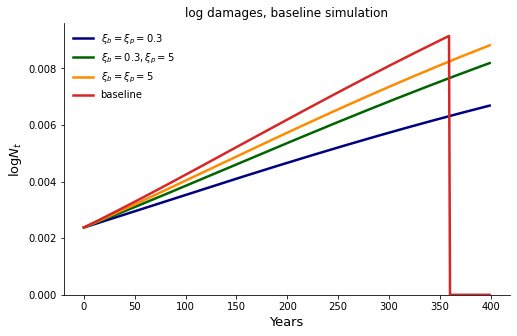

In [131]:
# log damage, baseline
fig = plt.figure(figsize=(8,5))
# plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_browian*γ1 + γ2/2*yt_browian**2) - np.log(et_brownian) + np.log(η) - np.log(1 -η), label="brownian robust, jump robust", color="tab:blue")
# plt.plot( np.log(1000) + np.log(Ct[0])  - (yt_smooth*γ1 + γ2/2*yt_smooth**2) - np.log(et_smooth) + np.log(η) - np.log(1 -η), label="smooth ambiguity, jump robust", color="darkgreen")


plt.plot( (yt_e1*γ1 + γ2/2*yt_e1**2), label="$ξ_b = ξ_p = 0.3$", color="navy")
plt.plot(  (yt_3*γ1 + γ2/2*yt_3**2) , label="$ξ_b =0.3, ξ_p = 5$", color="darkgreen")
# plt.plot( np.log(1000) - np.log(et) + np.log(η) - np.log(1 -η), label="with drift term + jump robust")
plt.plot(  (yt_e2*γ1 + γ2/2*yt_e2**2) , label="$ξ_b = ξ_p = 5$", color="darkorange")
plt.plot(  (yt_bb*γ1 + γ2/2*yt_bb**2) , label="baseline", color="tab:red")
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
# plt.legend(frameon=False)
plt.ylim(0)
plt.title("log damages, baseline simulation")
plt.ylabel('$\log N_t$', fontsize=13)
plt.xlabel('Years', fontsize=13)
# plt.title('$ \log(1000) -\log{\mathcal{E}_t} + \log \eta  - \log (1 - \eta)$')
# plt.savefig("./paper_plots/logscc.pdf")
# plt.savefig("./paper_plots/logn_baseline.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

Text(0.5, 0, 'Years')

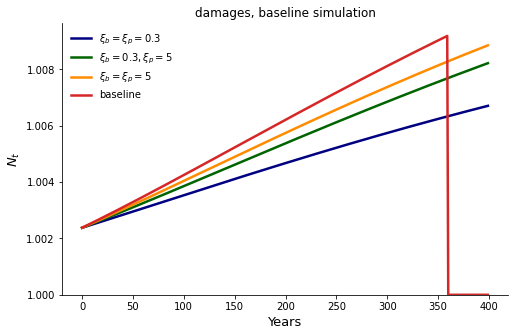

In [132]:
# damages,baseline simulation
fig = plt.figure(figsize=(8,5))
plt.plot(np.exp(yt_e1*γ1 + γ2/2*yt_e1**2), label="$ξ_b = ξ_p = 0.3$", color="navy")
plt.plot( np.exp(yt_3*γ1 + γ2/2*yt_3**2) , label="$ξ_b =0.3, ξ_p = 5$", color="darkgreen")
# plt.plot( np.log(1000) - np.log(et) + np.log(η) - np.log(1 -η), label="with drift term + jump robust")
plt.plot(  np.exp(yt_e2*γ1 + γ2/2*yt_e2**2) , label="$ξ_b = ξ_p = 5$", color="darkorange")
plt.plot(  np.exp(yt_bb*γ1 + γ2/2*yt_bb**2) , label="baseline", color="tab:red")
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,2,3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
# plt.legend(frameon=False)
plt.ylim(1)
plt.title("damages, baseline simulation")
plt.ylabel('$N_t$', fontsize=13)
plt.xlabel('Years', fontsize=13)
# plt.title('$ \log(1000) -\log{\mathcal{E}_t} + \log \eta  - \log (1 - \eta)$')
# plt.savefig("./paper_plots/logscc.pdf")
# plt.savefig("./paper_plots/n_baseline.png",dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

Text(0.5, 0, 'Years')

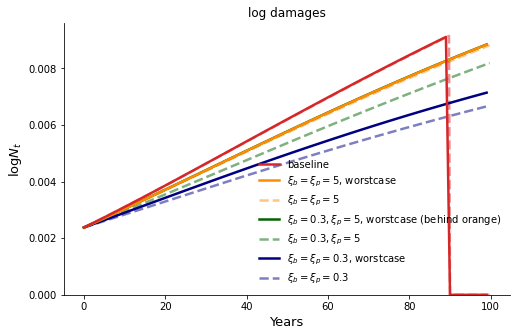

In [134]:
# log damages, worstcase
fig = plt.figure(figsize=(8,5))

plt.plot( years, (yt_e1*γ1 + γ2/2*yt_e1**2), label="$ξ_b = ξ_p = 0.3$", color="navy", alpha=0.5, linestyle="dashed")
plt.plot( years, (yt_3*γ1 + γ2/2*yt_3**2) , label="$ξ_b =0.3, ξ_p = 5$", color="darkgreen", alpha=0.5, linestyle="dashed")
plt.plot( years,  (yt_e2*γ1 + γ2/2*yt_e2**2) , label="$ξ_b = ξ_p = 5$", color="darkorange", alpha=0.5, linestyle="dashed")
plt.plot( years, (yt_bb*γ1 + γ2/2*yt_bb**2) , label="baseline", color="tab:red", alpha=0.5, linestyle="dashed")

plt.plot( (yt_e1w*γ1 + γ2/2*yt_e1w**2), label="$ξ_b = ξ_p = 0.3$, worstcase", color="navy")
plt.plot(  (yt_3w*γ1 + γ2/2*yt_3w**2) , label="$ξ_b =0.3, ξ_p = 5$, worstcase (behind orange)", color="darkgreen")
plt.plot(  (yt_e2w*γ1 + γ2/2*yt_e2w**2) , label="$ξ_b = ξ_p = 5$, worstcase", color="darkorange")
plt.plot(  (yt_bbw*γ1 + γ2/2*yt_bbw**2) , label="baseline", color="tab:red")
handles, labels = plt.gca().get_legend_handles_labels()
order = [7,6,2, 5, 1, 4,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
# plt.legend(frameon=False)
plt.ylim(0)
plt.title("log damages")
plt.ylabel('$\log N_t$', fontsize=13)
plt.xlabel('Years', fontsize=13)
# plt.title('$ \log(1000) -\log{\mathcal{E}_t} + \log \eta  - \log (1 - \eta)$')
# plt.savefig("./paper_plots/logscc.pdf")
# plt.savefig("./paper_plots/logn.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

Text(0.5, 0, 'Years')

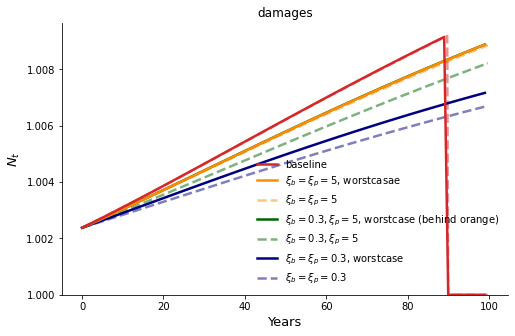

In [136]:
# damages, worstcase simulation
fig = plt.figure(figsize=(8,5))
plt.plot(years, np.exp(yt_e1*γ1 + γ2/2*yt_e1**2), label="$ξ_b = ξ_p = 0.3$", color="navy", alpha=0.5, linestyle="dashed")
plt.plot(years, np.exp(yt_3*γ1 + γ2/2*yt_3**2) , label="$ξ_b =0.3, ξ_p = 5$", color="darkgreen", alpha=0.5, linestyle="dashed")
plt.plot(years,  np.exp(yt_e2*γ1 + γ2/2*yt_e2**2) , label="$ξ_b = ξ_p = 5$", color="darkorange", alpha=0.5, linestyle="dashed")
plt.plot(years,  np.exp(yt_bb*γ1 + γ2/2*yt_bb**2) , label="baseline", color="tab:red", alpha=0.5, linestyle="dashed")

plt.plot(np.exp(yt_e1w*γ1 + γ2/2*yt_e1w**2), label="$ξ_b = ξ_p = 0.3$, worstcase", color="navy")
plt.plot( np.exp(yt_3w*γ1 + γ2/2*yt_3w**2) , label="$ξ_b =0.3, ξ_p = 5$, worstcase (behind orange)", color="darkgreen")
plt.plot(  np.exp(yt_e2w*γ1 + γ2/2*yt_e2w**2) , label="$ξ_b = ξ_p = 5$, worstcasae", color="darkorange")
plt.plot(  np.exp(yt_bbw*γ1 + γ2/2*yt_bbw**2) , label="baseline", color="tab:red")
handles, labels = plt.gca().get_legend_handles_labels()
order = [7,6,2, 5, 1, 4,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False)
# plt.legend(frameon=False)
plt.ylim(1)
plt.title("damages")
plt.ylabel('$N_t$', fontsize=13)
plt.xlabel('Years', fontsize=13)
# plt.title('$ \log(1000) -\log{\mathcal{E}_t} + \log \eta  - \log (1 - \eta)$')
# plt.savefig("./paper_plots/logscc.pdf")
# plt.savefig("./paper_plots/n.png", dpi=500, facecolor="w", edgecolor="w", bbox_inches="tight")

<ipython-input-137-a1531639c577>:1: RuntimeWarning: divide by zero encountered in true_divide
  me = δ*η/et_bb


IndexError: boolean index did not match indexed array along dimension 0; dimension is 100 but corresponding boolean dimension is 400

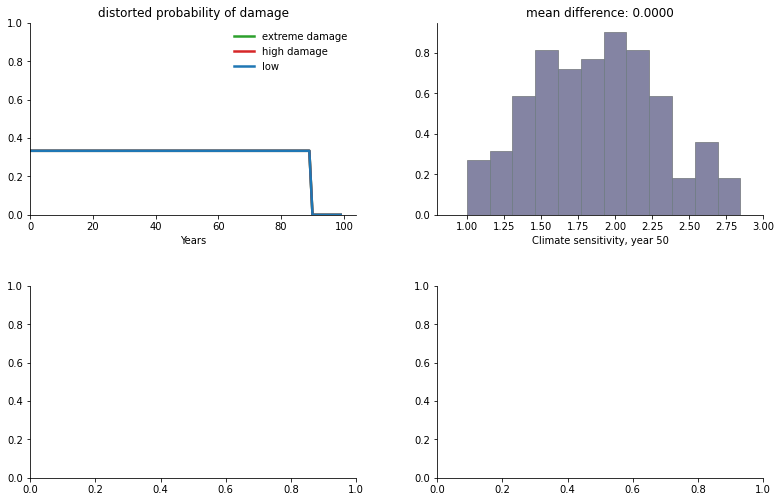

In [137]:
me = δ*η/et_bb
et_base = et_bb
fig, ((ax1, ax2), (ax3, ax4)) = plot_together(et,  θ_list, ht, πᶜt, πᵈt, me, dmg_weight)
fig.suptitle("$ξ_a = 1/100,\ ξ_w = 1/3.4,\ ξ_p =  5$")
# plt.savefig('15_600_1.pdf')
plt.show()